In [ ]:
# comment out this code if you have libraries installed
!pip install requirements.txt

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from itertools import combinations

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import json,pickle
from graphviz import Source
import shap
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import KNeighborsClassifier


import scipy.stats as sps

In [208]:
df = pd.read_csv('data.csv',index_col='lucid_id')

## EXPLORATORY ANALYSIS AND CLEANING

In [209]:
#identifying null columns to analyse how to encode them. low cardinality ones can be target encoded.
for i in df.columns:
    null_count = df[i].isnull().sum()
    if null_count>0:
        print(i, null_count, df[i].nunique())

VarianceTable$variance_table$bank$day_first_seen 10278 2146
VarianceTable$variance_table$bank$day_last_seen 10278 1590
VarianceTable$variance_table$device$parent 10178 235
VarianceTable$variance_table$device$platform 10178 13
VarianceTable$variance_table$device$browser 10178 29
VarianceTable$variance_table$device$device_type 10178 6
VarianceTable$variance_table$device$device_pointing_method 10178 3
VarianceTable$variance_table$device$is_mobile_device 10178 2
VarianceTable$variance_table$device$is_tablet 10178 2
VarianceTable$variance_table$device$crawler 10178 2
VarianceTable$variance_table$driver_license$is_valid 7967 2
VarianceTable$variance_table$email$day_first_seen 6221 2146
VarianceTable$variance_table$email$day_last_seen 6221 1714
VarianceTable$variance_table$employer$employer_name 3 4
VarianceTable$variance_table$ip$ip 257 3
VarianceTable$variance_table$phone$day_first_seen 5816 2147
VarianceTable$variance_table$phone$day_last_seen 5816 1686
VarianceTable$variance_table$phone$h

In [210]:
#cleaning column names for clarity
df.columns = df.columns.str.replace(r'[^\w]+', '_', regex=True)

In [211]:
categorical_columns = df.select_dtypes(exclude = np.number).columns
for col in categorical_columns:
    if df[col].isnull().sum()>0:
        df[col] = df[col].fillna("Missing")

In [212]:
#dropping day feature since we already had number of days since first/last seen and whether they are new or not

days_features = [col for col in df.columns if 'day_first_seen' in col or 'day_last_seen' in col]

df = df.drop(columns=days_features,axis=1, errors='ignore')

In [213]:
df['lb_months_at_address_missing'] = df['lb_months_at_address'].isnull().astype(bool)
df['lb_months_at_address'] = df['lb_months_at_address'].fillna(df['lb_months_at_address'].median())

In [214]:
#identifying null columns
for i in df.columns:
    null_count = df[i].isnull().sum()
    if null_count>0:
        print(i, null_count, df[i].nunique())

In [215]:
#!pip install category_encoders

In [216]:
#Rare email domains were grouped under "Other" to reduce dimensionality and highlight stability 
top_exts = df['VarianceTable_variance_table_email_extension'].value_counts().nlargest(20).index
df['email_ext_grouped'] = df['VarianceTable_variance_table_email_extension'].apply(lambda x: x if x in top_exts else 'Other')
df = df.drop('VarianceTable_variance_table_email_extension',axis=1)

In [217]:
#target encoding device parent column due to high cardinality
from category_encoders import TargetEncoder

TE = TargetEncoder()
col_TE = ['email_ext_grouped','VarianceTable_variance_table_device_parent','PricingTool_predictions_min','PricingTool_predictions_ranked','PricingTool_predictions_min_max','PricingTool_predictions_max']
train_test = df.sample(frac=0.7)
TE.fit(train_test[col_TE],train_test['ln_fpd'])
temp1 = TE.transform(df[col_TE])
for col in temp1.columns:
      temp1.rename(columns={col:col + '_TE'}, inplace=True)

df = pd.concat([df,temp1], axis = 1)
df = df.drop('VarianceTable_variance_table_device_parent',axis=1)




In [73]:
import pickle

with open("TE.pkl", "wb") as f:
    pickle.dump(TE, f)

In [218]:
df

lead_datetime  \
lucid_id                        
1         2024-09-20 00:00:00   
2         2024-09-23 00:00:00   
3         2024-09-18 00:00:00   
4         2024-09-20 00:00:00   
5         2024-09-17 00:00:00   
...                       ...   
58797     2023-01-01 00:00:00   
58798     2023-01-03 00:00:00   
58799     2023-01-07 00:00:00   
58800     2023-01-07 00:00:00   
58801     2023-01-09 00:00:00   

          VarianceTable_cross_variance_table_bank_account_ssn_count_1_day  \
lucid_id                                                                    
1                                                         1                 
2                                                         0                 
3                                                         1                 
4                                                         1                 
5                                                         0                 
...                                                     ...                 
58797                                                     0                 
58798                                                     0                 
58799                                                     1                 
58800                                                     0                 
58801                                                     0                 

          VarianceTable_cross_variance_table_bank_account_ssn_count_7_days  \
lucid_id                                                                     
1                                                         1                  
2                                                         0                  
3                                                         1                  
4                                                         1                  
5                                                         0                  
...                                                     ...                  
58797                                                     0                  
58798                                                     0                  
58799                                                     1                  
58800                                                     0                  
58801                                                     1                  

          VarianceTable_cross_variance_table_bank_account_ssn_count_30_days  \
lucid_id                                                                      
1                                                         1                   
2                                                         0                   
3                                                         1                   
4                                                         1                   
5                                                         0                   
...                                                     ...                   
58797                                                     0                   
58798                                                     0                   
58799                                                     1                   
58800                                                     0                   
58801                                                     1                   

          VarianceTable_cross_variance_table_bank_account_ssn_count_90_days  \
lucid_id                                                                      
1                                                         1                   
2                                                         0                   
3                                                         1                   
4                                                         1                   
5                                                         0        

In [219]:
df.describe()

VarianceTable_cross_variance_table_bank_account_ssn_count_1_day  \
count                                       58801.000000                 
mean                                            0.343481                 
std                                             0.527794                 
min                                             0.000000                 
25%                                             0.000000                 
50%                                             0.000000                 
75%                                             1.000000                 
max                                            32.000000                 

       VarianceTable_cross_variance_table_bank_account_ssn_count_7_days  \
count                                       58801.000000                  
mean                                            0.497713                  
std                                             0.811670                  
min                                             0.000000                  
25%                                             0.000000                  
50%                                             0.000000                  
75%                                             1.000000                  
max                                            82.000000                  

       VarianceTable_cross_variance_table_bank_account_ssn_count_30_days  \
count                                       58801.000000                   
mean                                            0.664070                   
std                                             2.308412                   
min                                             0.000000                   
25%                                             0.000000                   
50%                                             1.000000                   
75%                                             1.000000                   
max                                           313.000000                   

       VarianceTable_cross_variance_table_bank_account_ssn_count_90_days  \
count                                       58801.000000                   
mean                                            0.834169                   
std                                             6.073246                   
min                                             0.000000                   
25%                                             0.000000                   
50%                                             1.000000                   
75%                                             1.000000                   
max                                           885.000000                   

       VarianceTable_cross_variance_table_bank_account_ssn_count_365_days  \
count                                       58801.000000                    
mean                                            1.114318                    
std                                            17.893898                    
min                                             0.000000                    
25%                                             1.000000                    
50%                                             1.000000                    
75%                                             1.000000                    
max                                          2797.000000                    

       VarianceTable_cross_variance_table_bank_account_ssn_count_all_time  \
count                                       58801.000000                    
mean                                            1.709750                    
std                                            65.778774                    
min                                             0.000000                    
25%                                             1.000000                    
50%                                             1.000000                    
75%                                             1.000000     

In [220]:
df.dtypes

lead_datetime                                                         object
VarianceTable_cross_variance_table_bank_account_ssn_count_1_day        int64
VarianceTable_cross_variance_table_bank_account_ssn_count_7_days       int64
VarianceTable_cross_variance_table_bank_account_ssn_count_30_days      int64
VarianceTable_cross_variance_table_bank_account_ssn_count_90_days      int64
                                                                      ...   
VarianceTable_variance_table_device_parent_TE                        float64
PricingTool_predictions_min_TE                                       float64
PricingTool_predictions_ranked_TE                                    float64
PricingTool_predictions_min_max_TE                                   float64
PricingTool_predictions_max_TE                                       float64
Length: 396, dtype: object

Text(0, 0.5, 'Number of Leads')

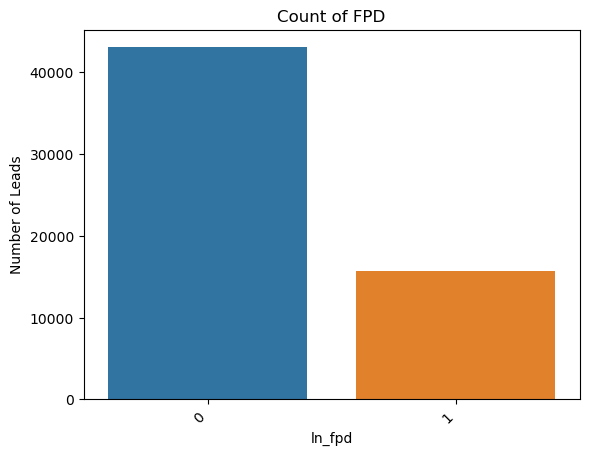

In [221]:
order = df['ln_fpd'].value_counts().index
sns.countplot(data=df, x='ln_fpd', order=order)
plt.xticks(rotation=45, ha='right')
plt.title(f'Count of FPD')
plt.ylabel('Number of Leads')

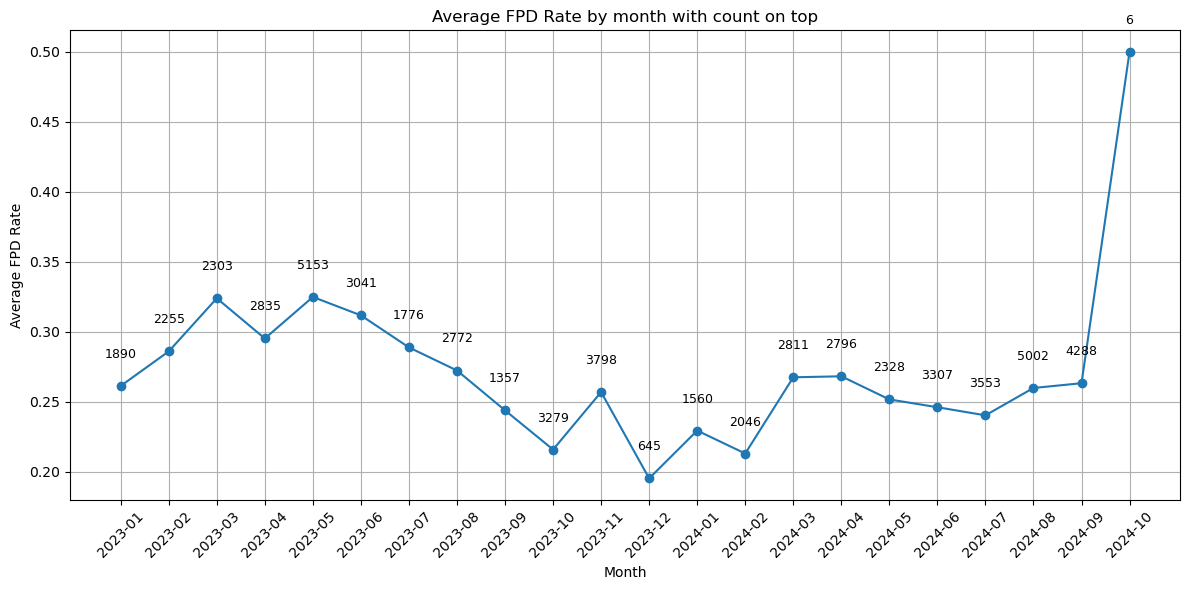

In [222]:
#EDA - how default rate has evolved with time
df['lead_datetime'] = pd.to_datetime(df['lead_datetime'], errors='coerce')


df['lead_month'] = df['lead_datetime'].dt.to_period('M')
df['lead_month_str'] = df['lead_month'].astype(str)


fpd_by_month = df.groupby('lead_month_str')['ln_fpd'].mean().reset_index()
fpd_by_month.columns = ['lead_month_str', 'Average_FPD_Rate']


lead_counts = df.groupby('lead_month_str').size().reset_index(name='Lead_Count')
lead_counts.columns = ['lead_month_str', 'Lead_Count']


fpd_by_month = pd.merge(fpd_by_month, lead_counts, on='lead_month_str')


plt.figure(figsize=(12, 6))
plt.plot(fpd_by_month['lead_month_str'], fpd_by_month['Average_FPD_Rate'], marker='o', label='Avg FPD Rate')
plt.xlabel('Month')
plt.ylabel('Average FPD Rate')
plt.title('Average FPD Rate by month with count on top')
plt.xticks(rotation=45)
plt.grid(True)

for i, row in fpd_by_month.iterrows():
    plt.text(row['lead_month_str'], row['Average_FPD_Rate'] + 0.02,
             str(row['Lead_Count']), ha='center', fontsize=9)

plt.tight_layout()
plt.show()
df = df.drop('lead_month_str',axis=1)

In [223]:
#removing constant columns as they offer no predictive insight
redundant_columns = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(redundant_columns,axis=1)

In [17]:
def plot_count_and_fpd(df, col, target='ln_fpd', min_count=20):
    plt.figure(figsize=(14, 6))

    # Count plot
    plt.subplot(1, 2, 1)
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order=order)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Count of {col}')
    plt.ylabel('Number of Leads')

    # Mean FPD bar plot (filtered by min count)
    plt.subplot(1, 2, 2)
    fpd_df = df.groupby(col).agg(
        fpd_rate=(target, 'mean'),
        count=(target, 'count')
    ).query(f'count >= {min_count}').sort_values('fpd_rate', ascending=False)

    sns.barplot(x=fpd_df.index, y=fpd_df['fpd_rate'], palette='coolwarm')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'FPD Rate by {col} (min {min_count} leads)')
    plt.ylabel('FPD Rate')

    plt.tight_layout()
    plt.show()


 VarianceTable_variance_table_address_state


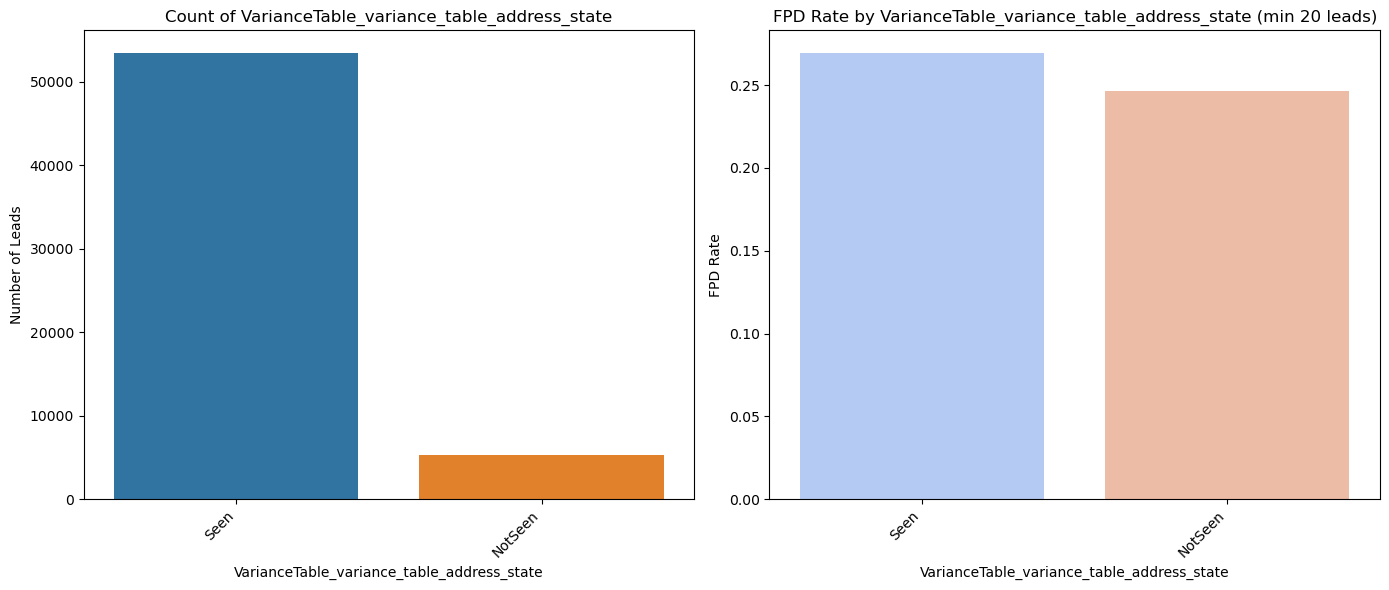


 VarianceTable_variance_table_address_zip


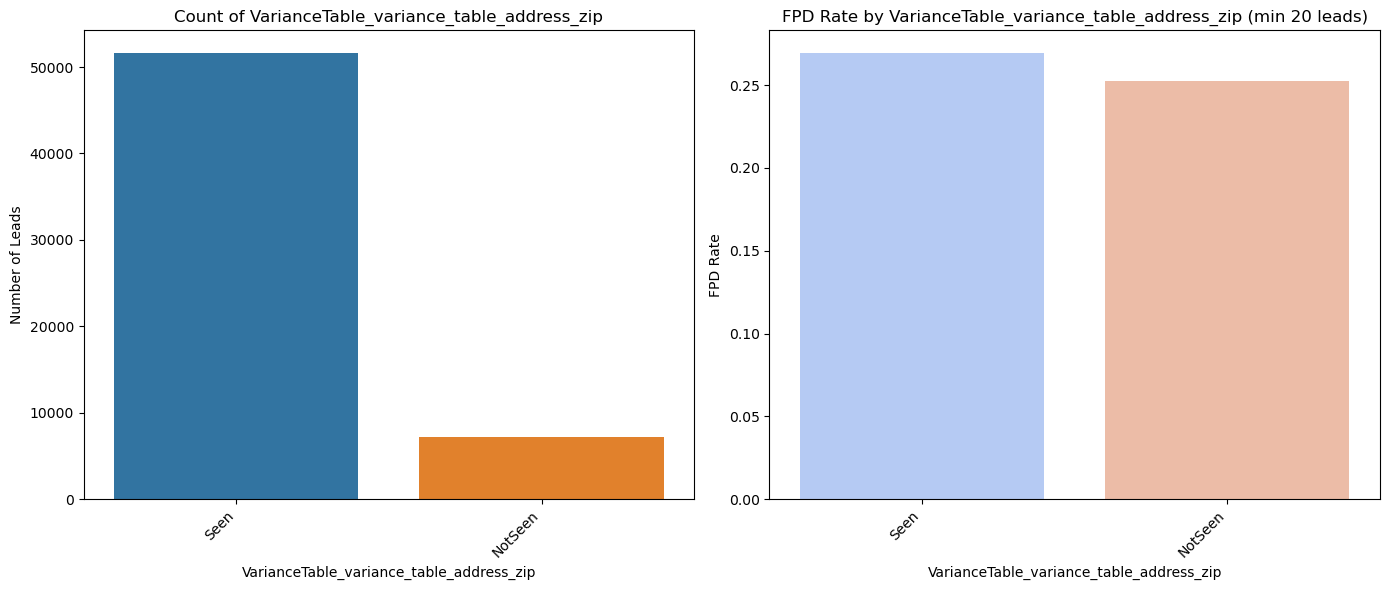


 VarianceTable_variance_table_address_city


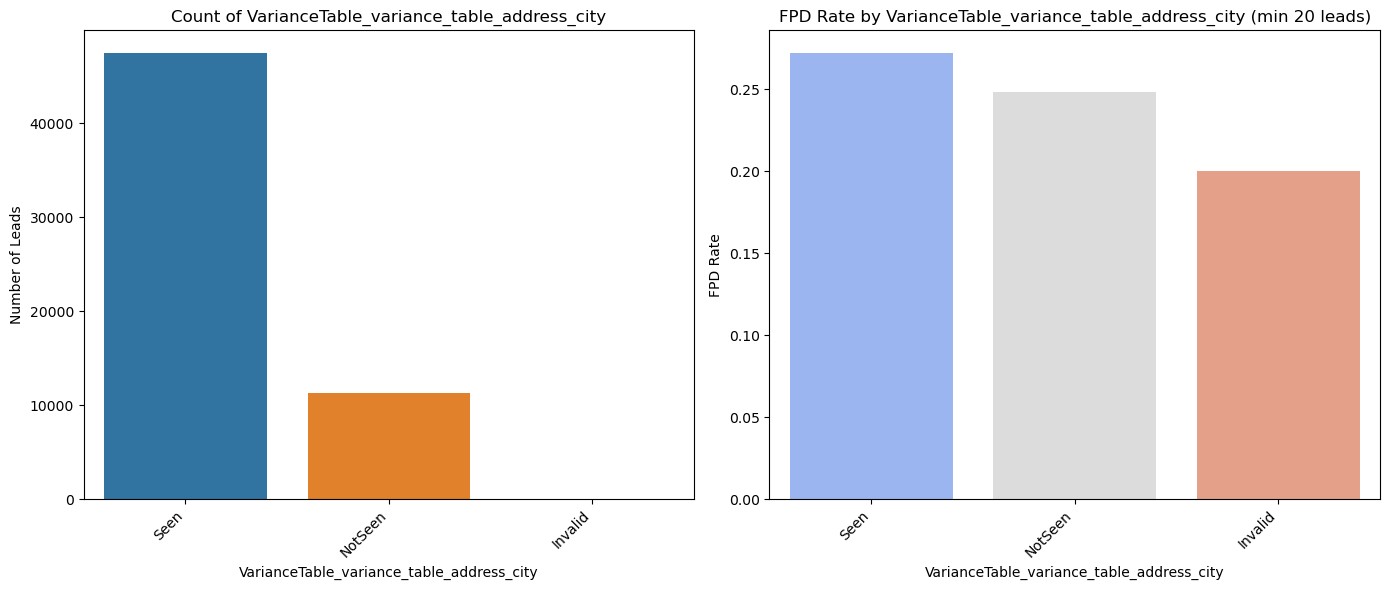


 VarianceTable_variance_table_address_address


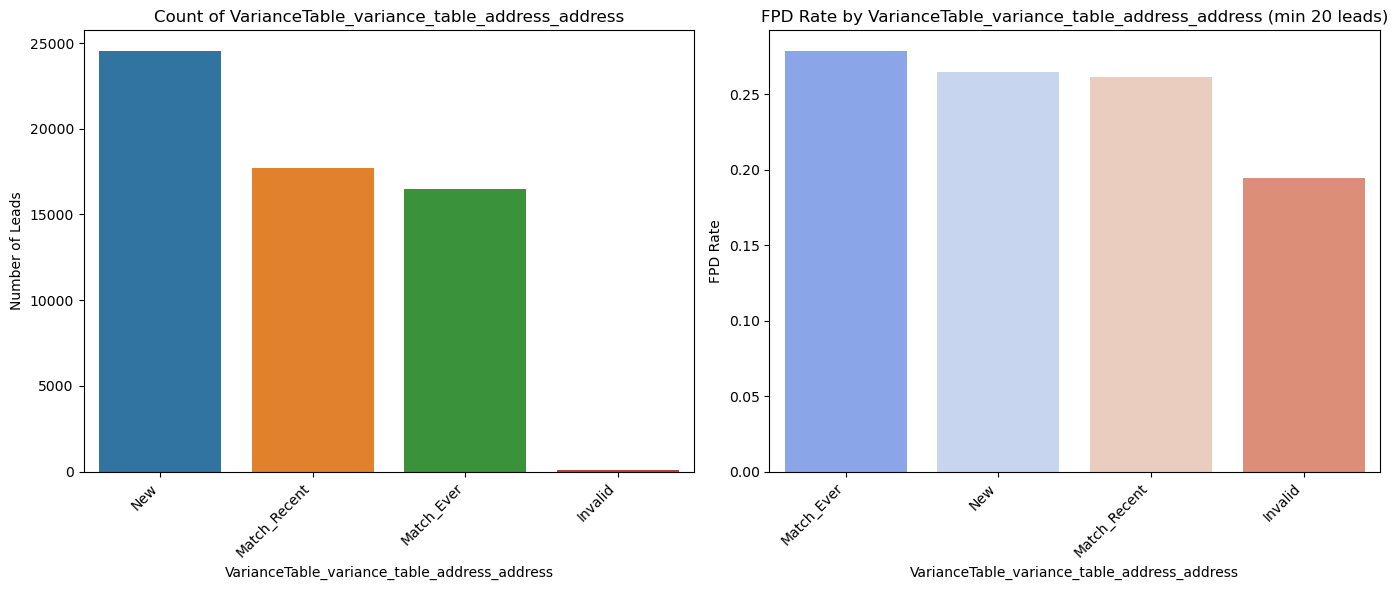


 VarianceTable_variance_table_bank_bank_account


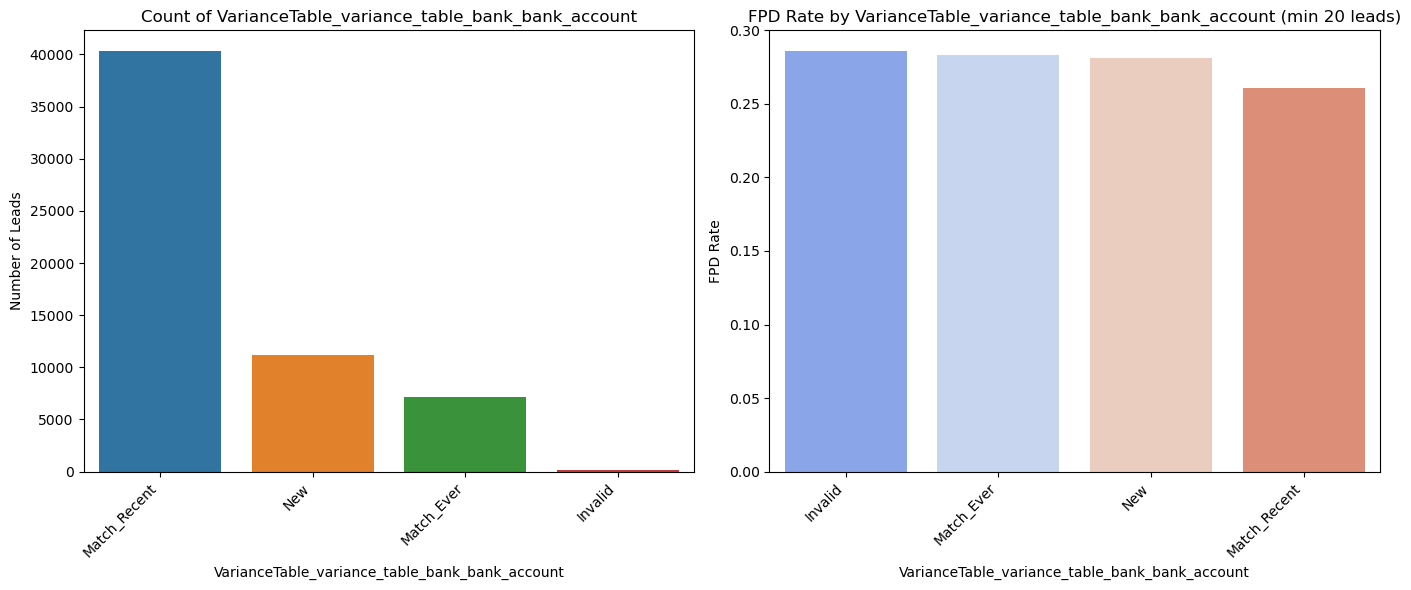


 VarianceTable_variance_table_bank_bank_aba


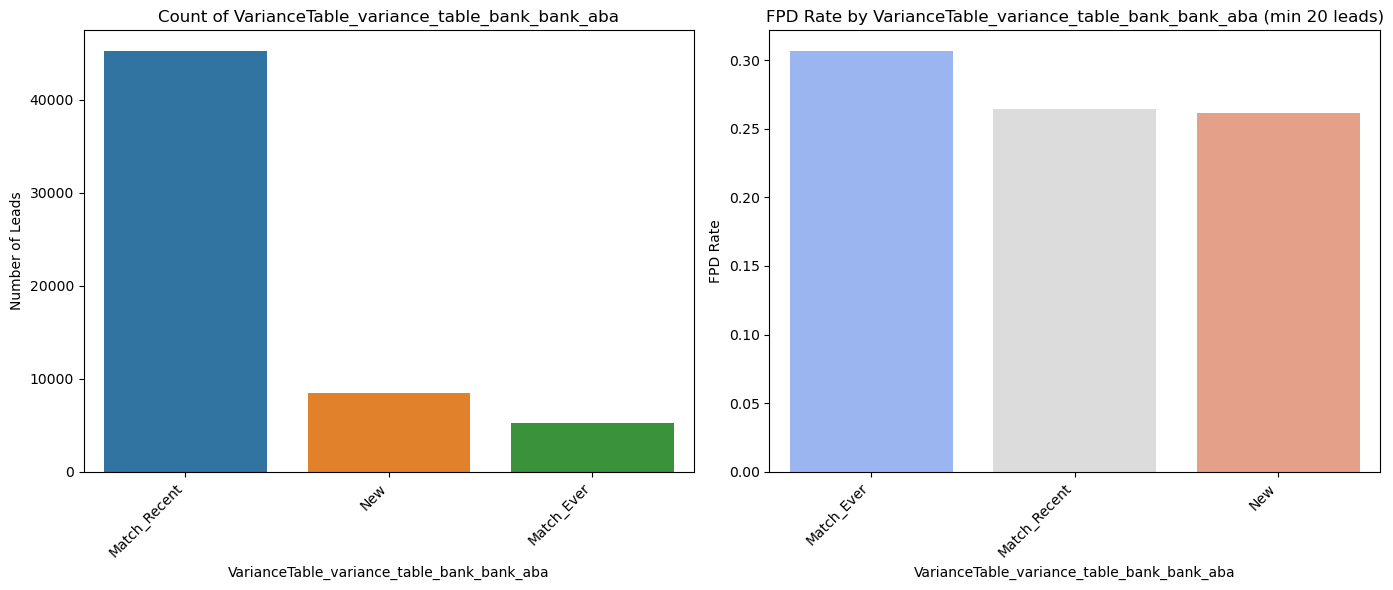


 VarianceTable_variance_table_bank_account_type


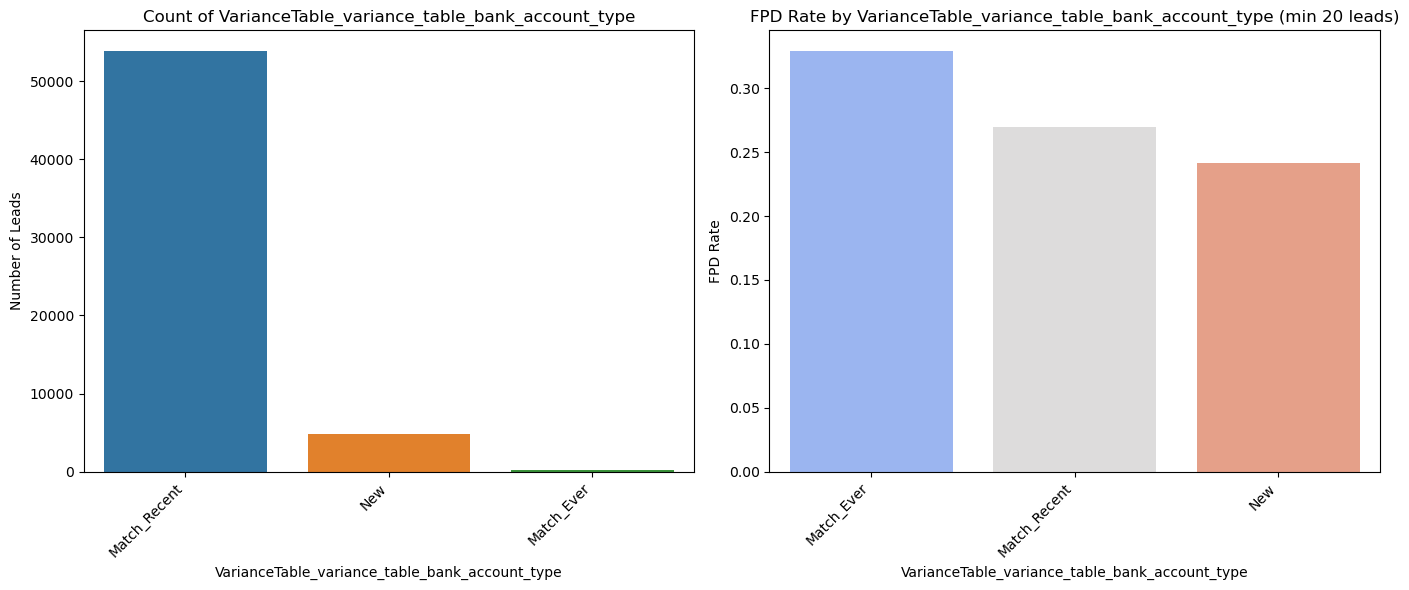


 VarianceTable_variance_table_device_parent


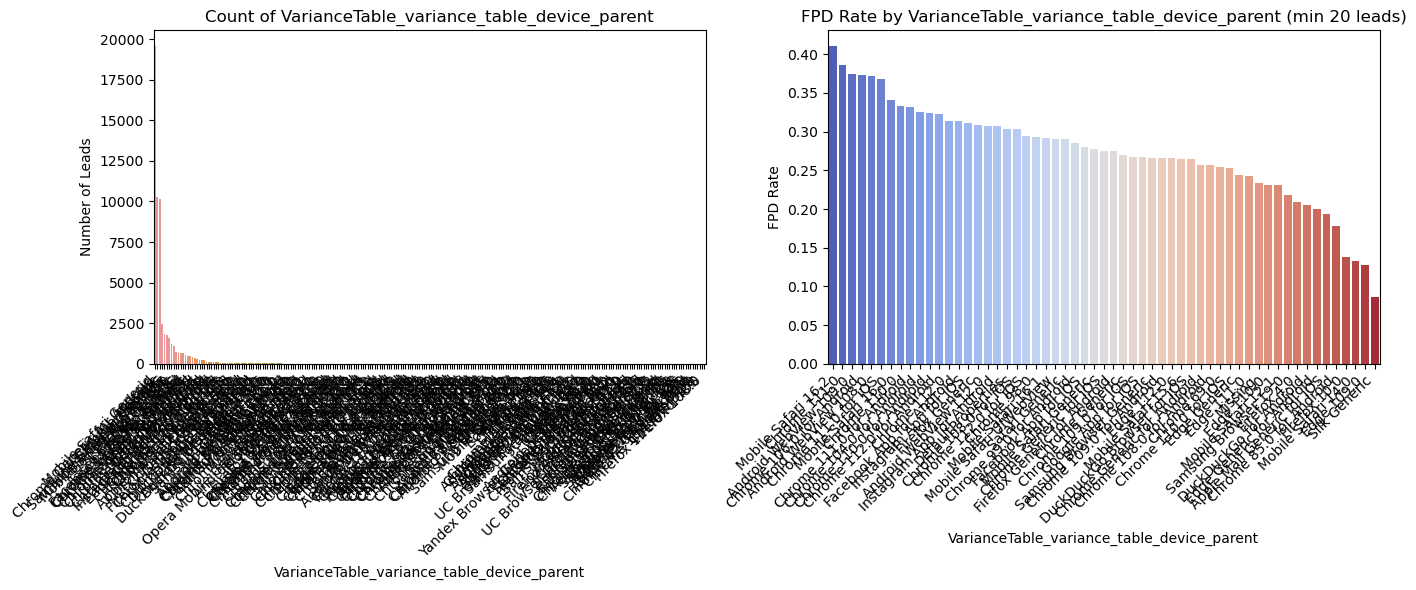


 VarianceTable_variance_table_device_platform


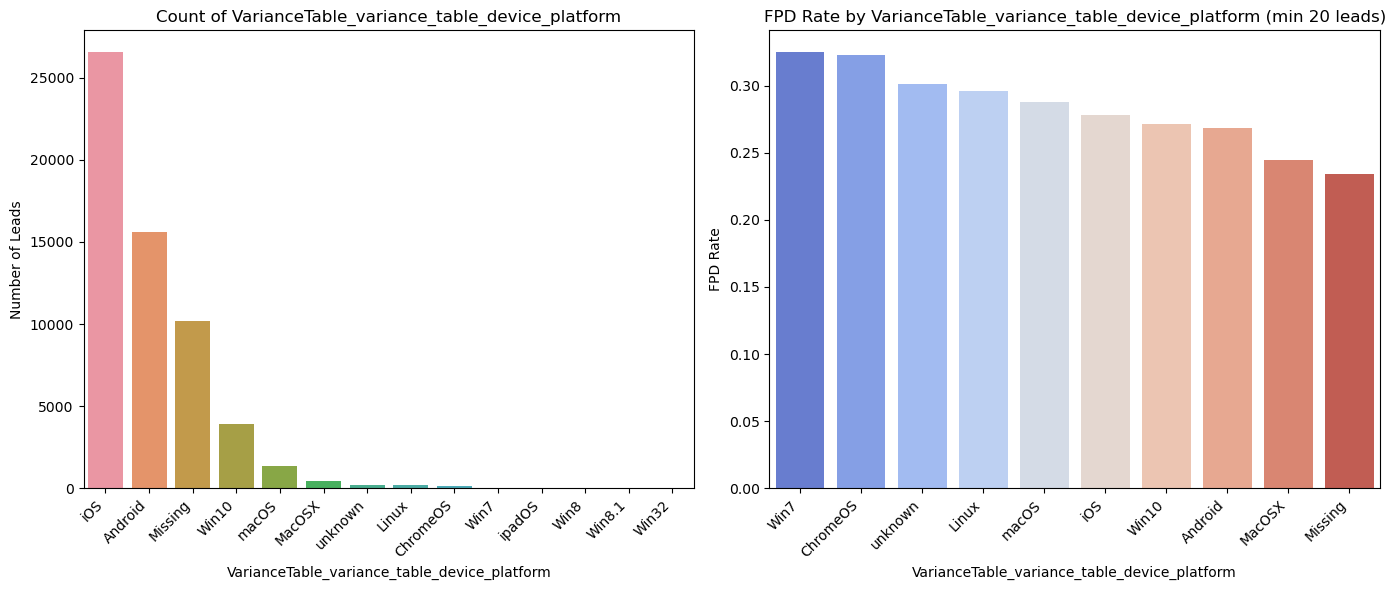


 VarianceTable_variance_table_device_browser


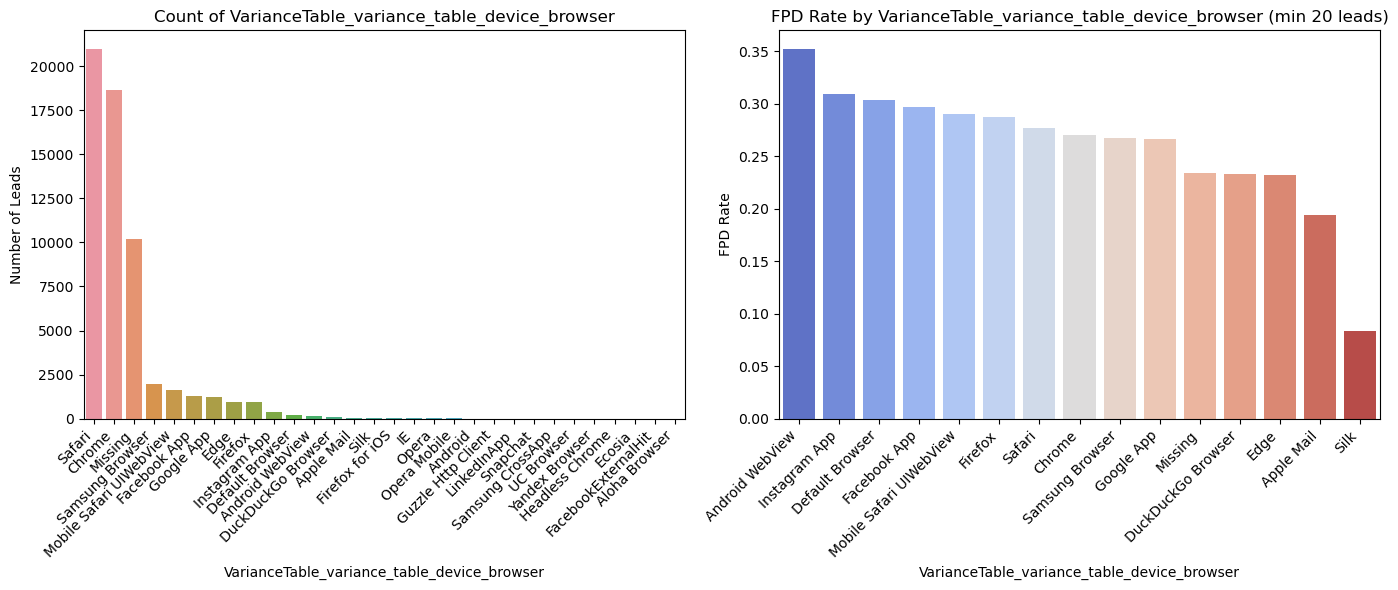


 VarianceTable_variance_table_device_device_type


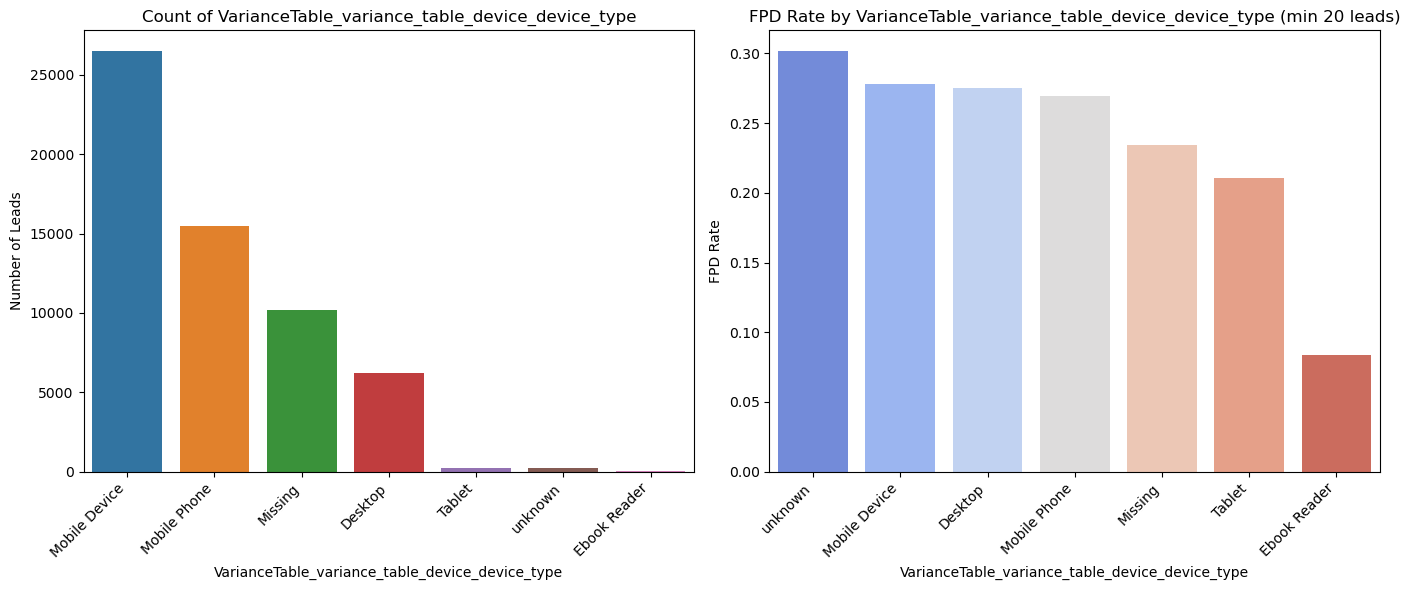


 VarianceTable_variance_table_device_device_pointing_method


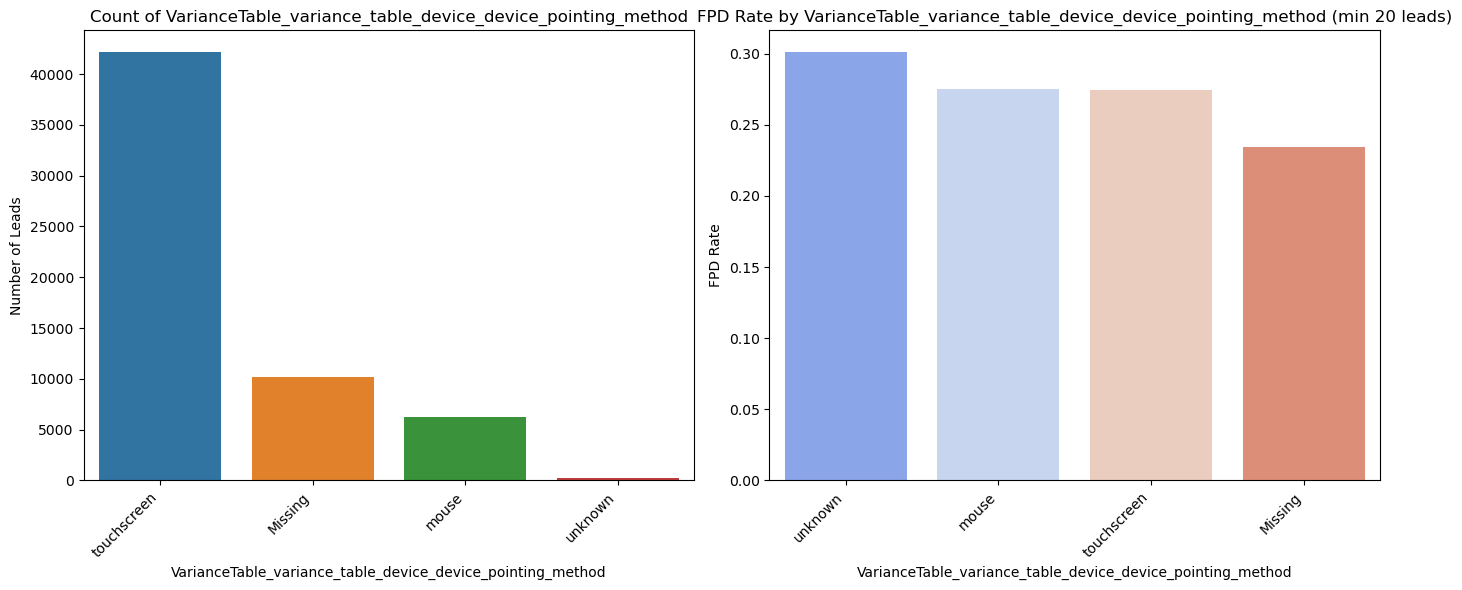


 VarianceTable_variance_table_device_is_mobile_device


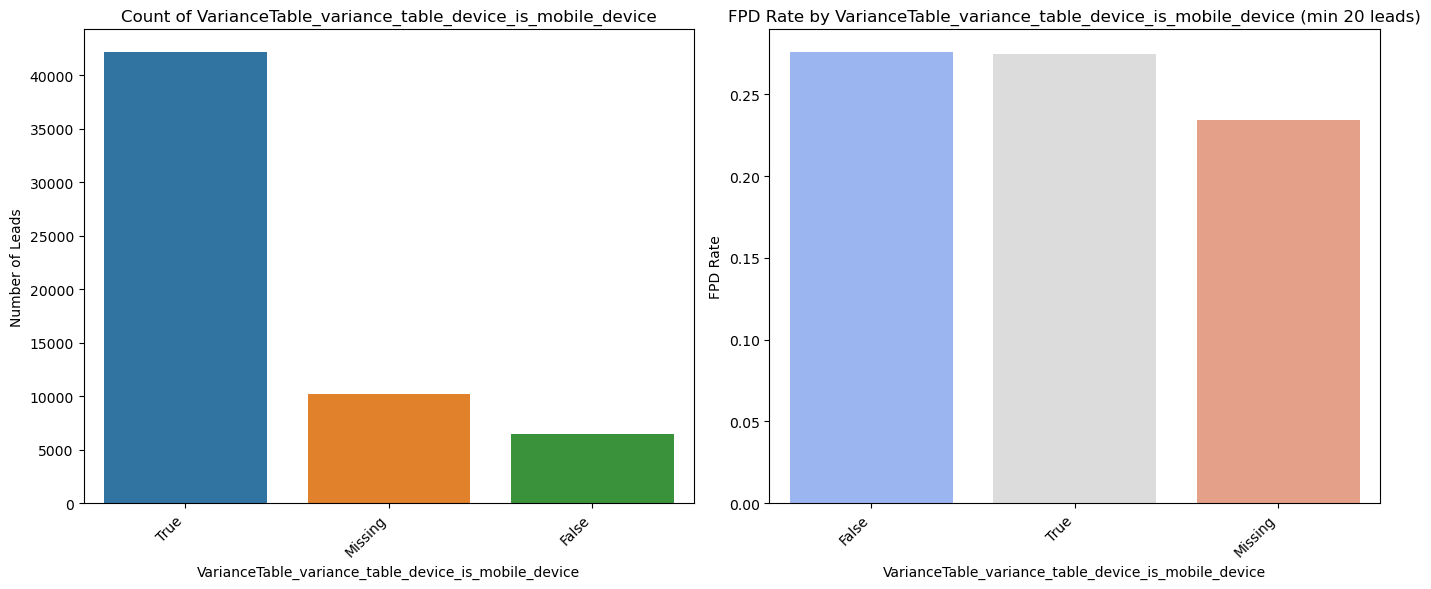


 VarianceTable_variance_table_device_is_tablet


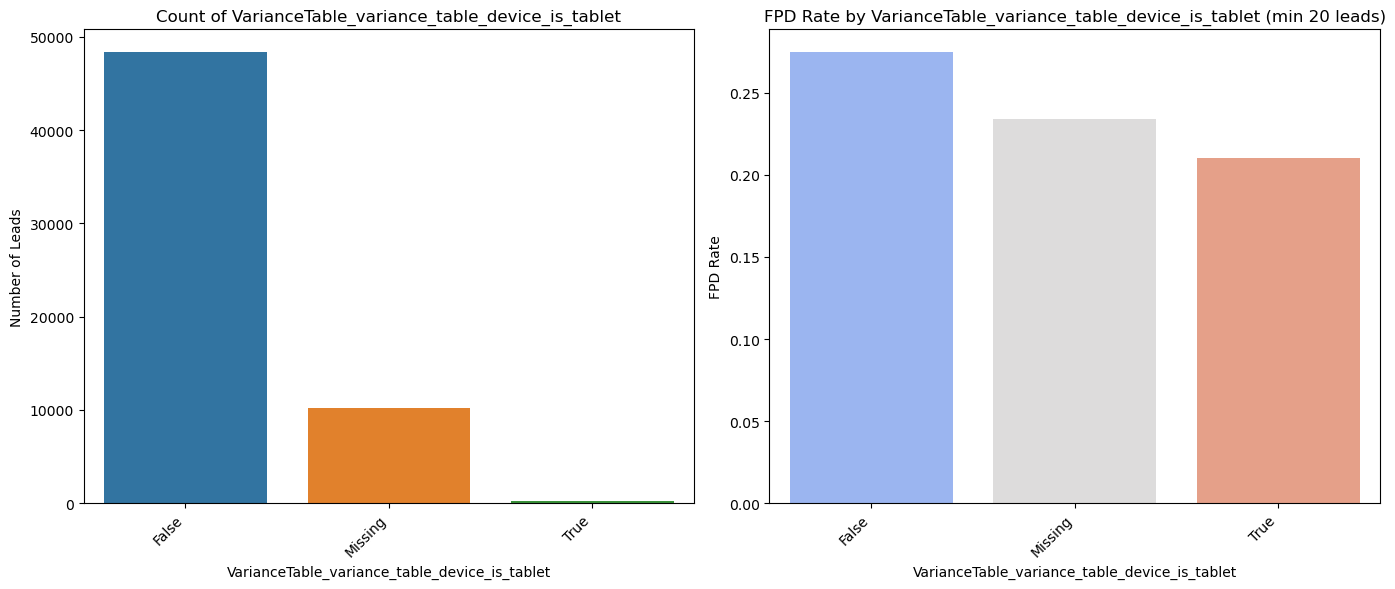


 VarianceTable_variance_table_device_crawler


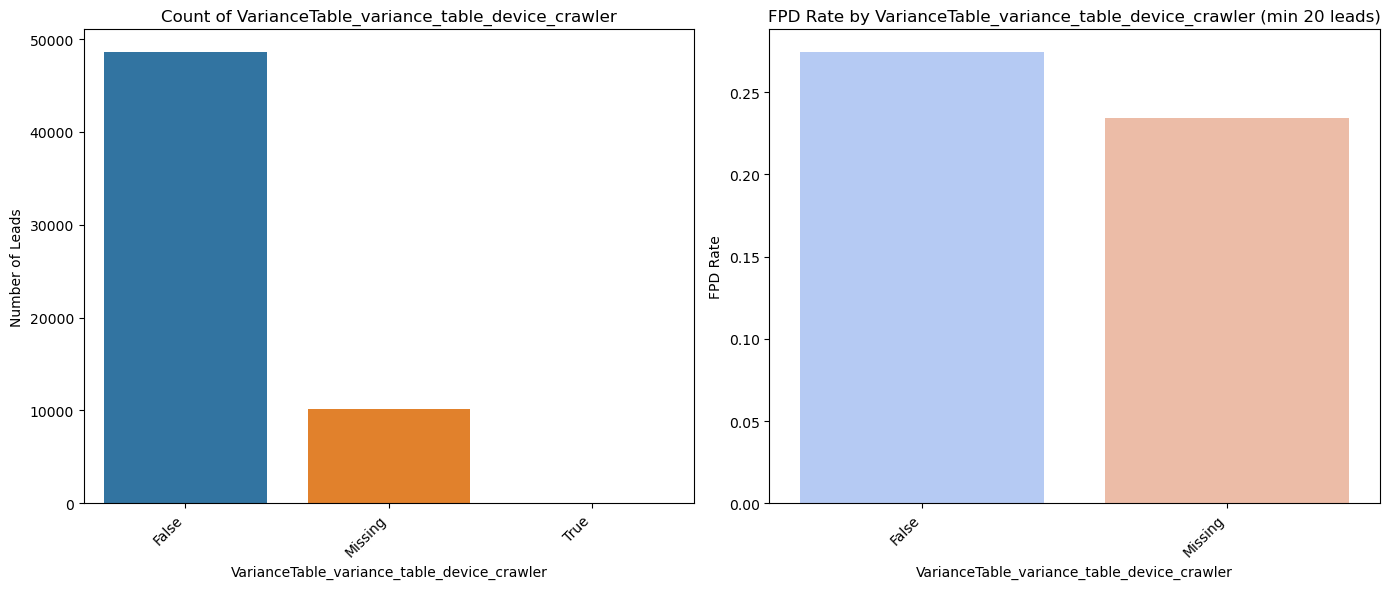


 VarianceTable_variance_table_dob_dob


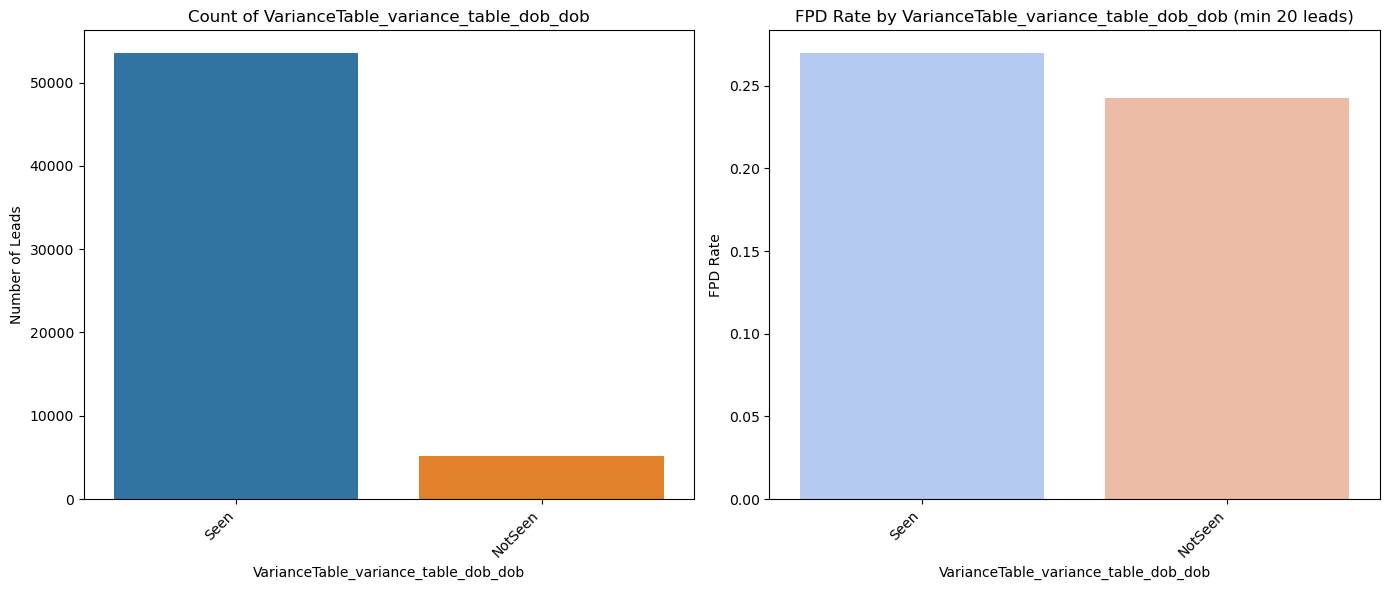


 VarianceTable_variance_table_driver_license_is_valid


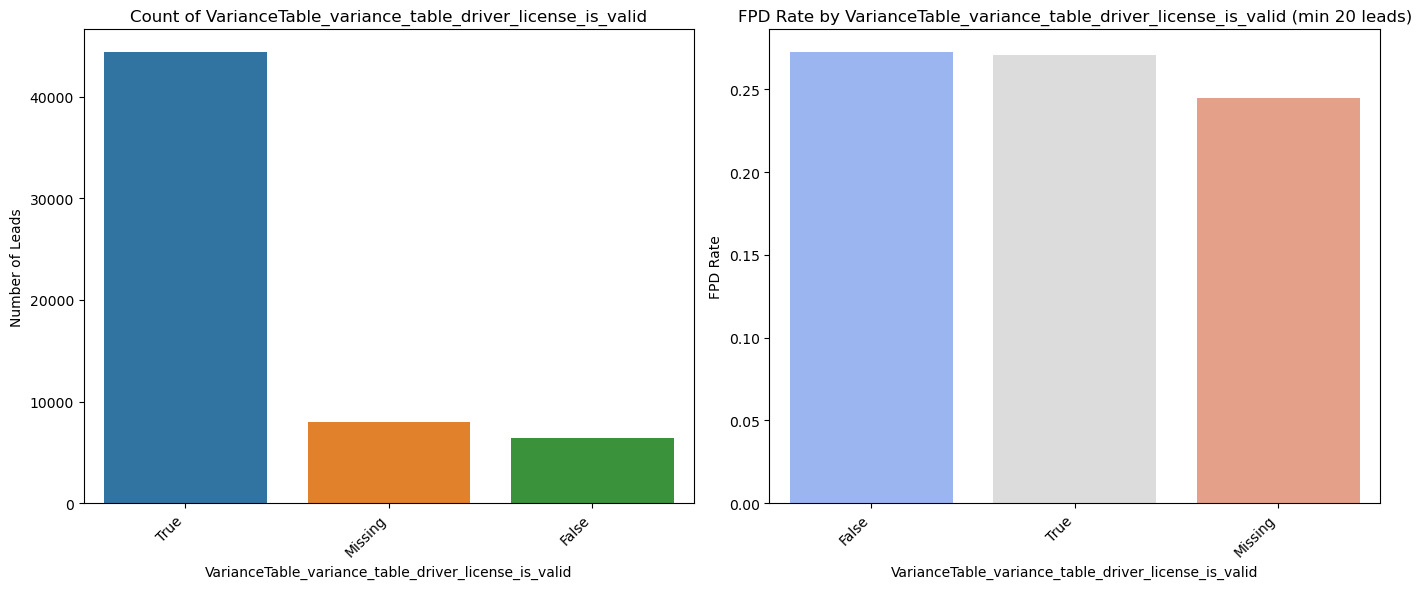


 VarianceTable_variance_table_driver_license_driver_license


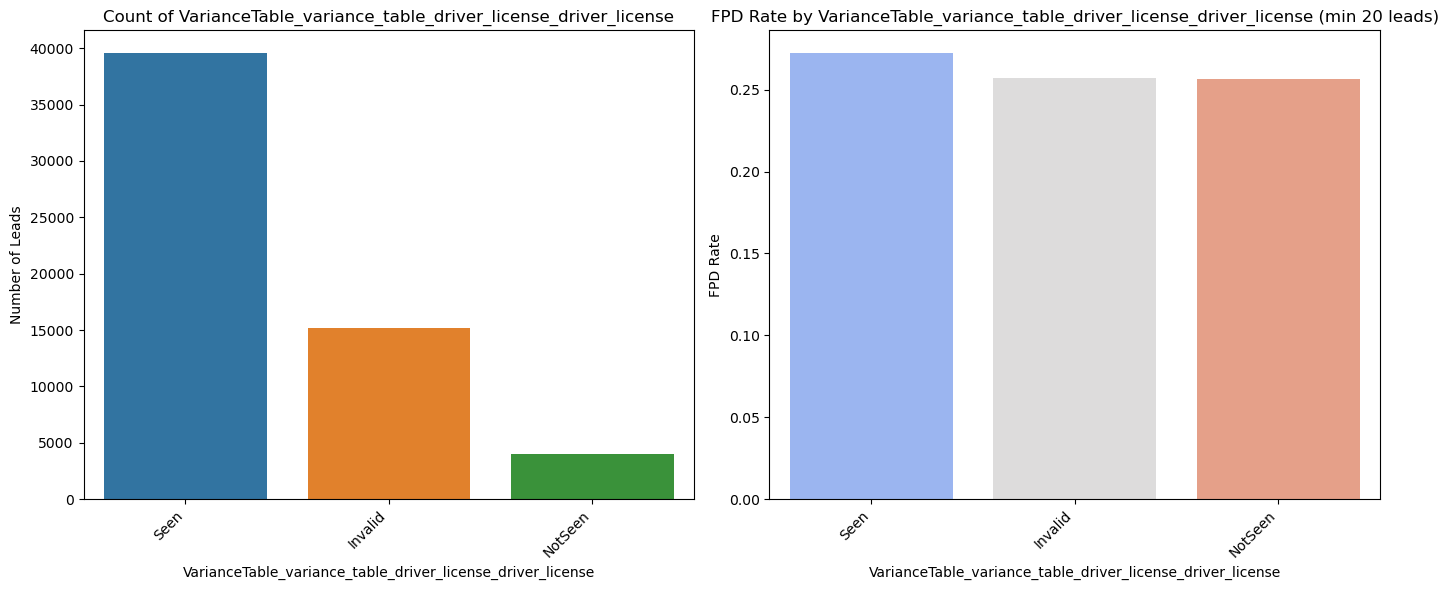


 VarianceTable_variance_table_email_email


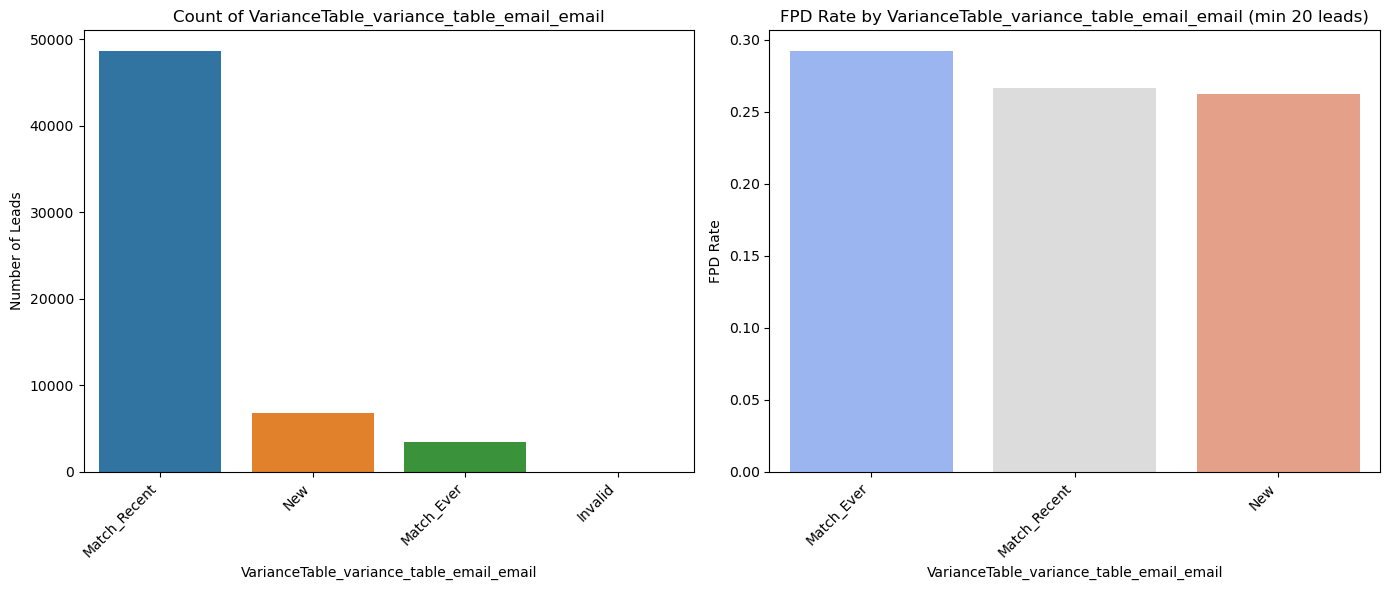


 VarianceTable_variance_table_email_extension


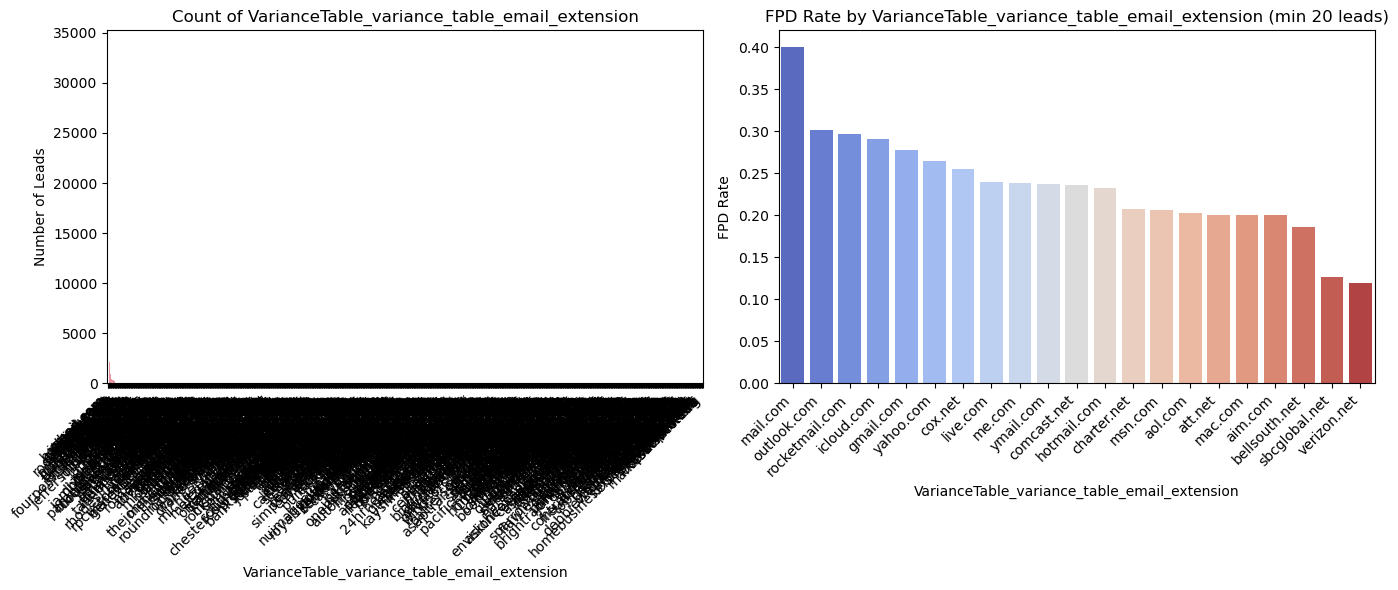


 VarianceTable_variance_table_employer_income


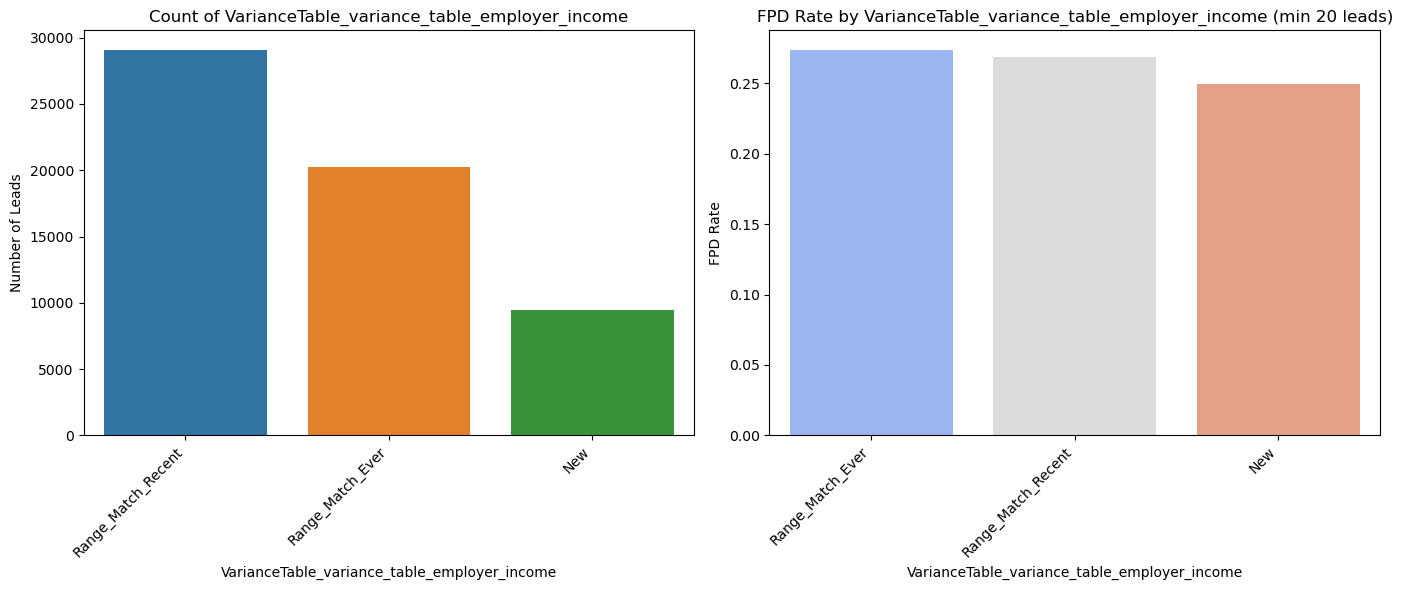


 VarianceTable_variance_table_employer_employer_name


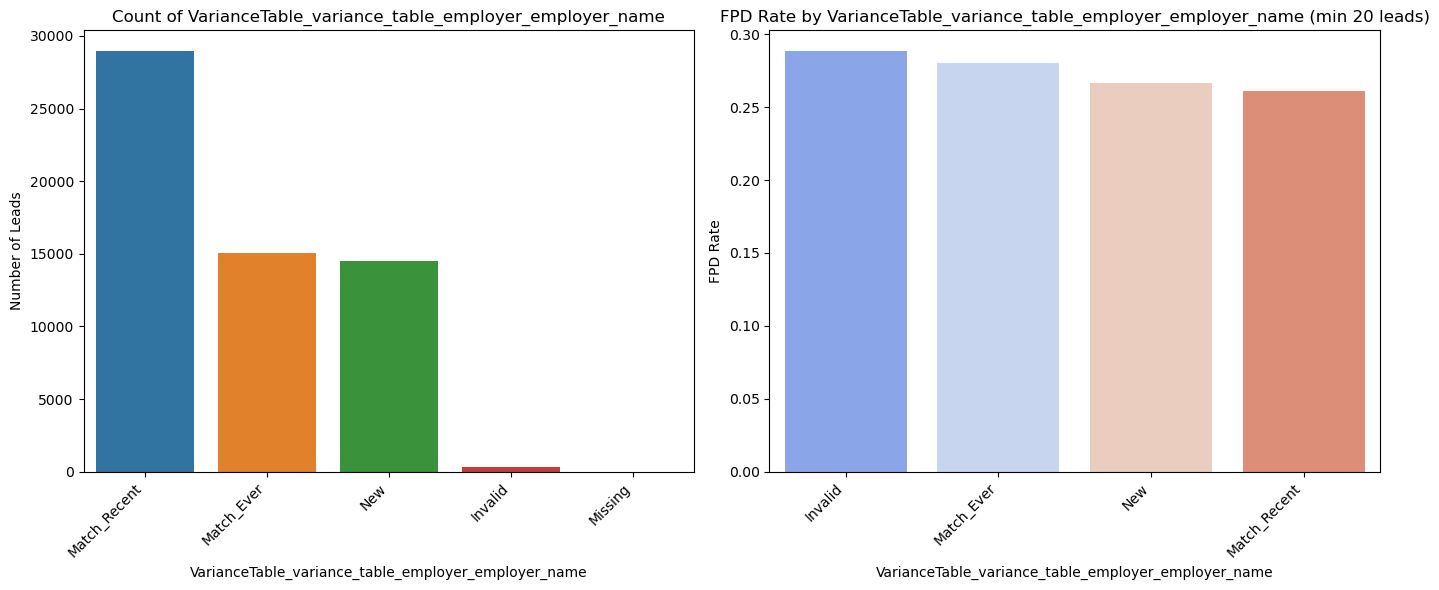


 VarianceTable_variance_table_employer_pay_frequency


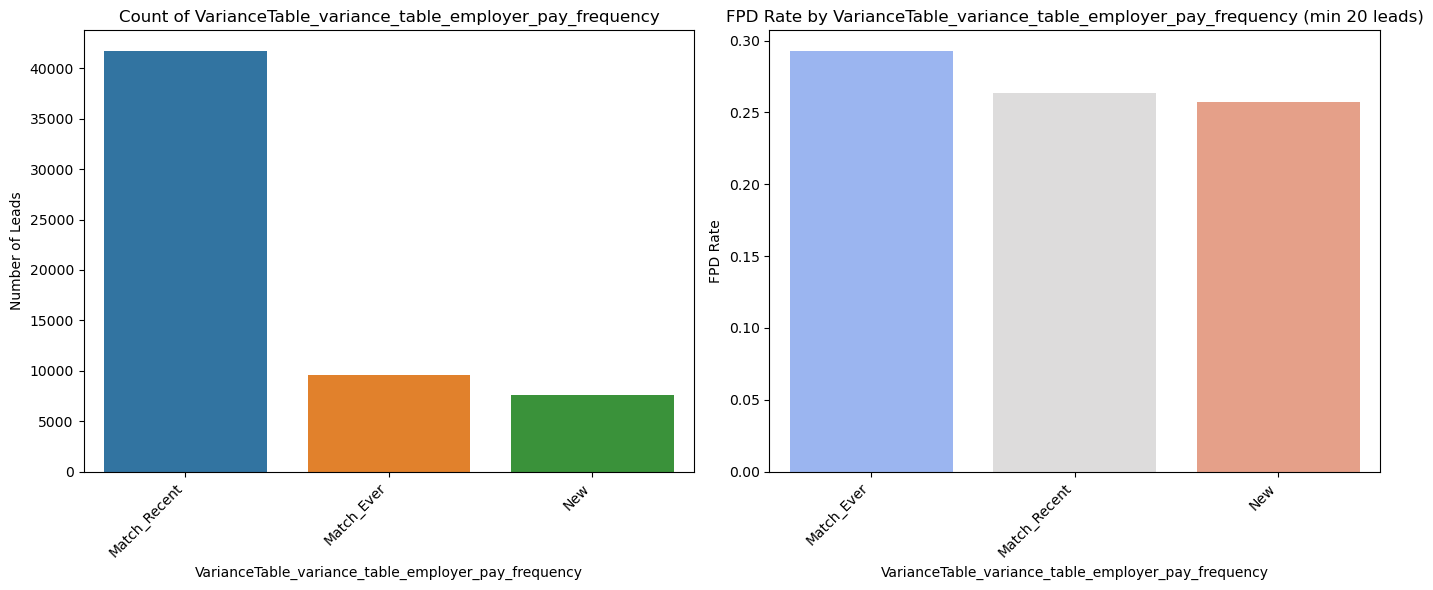


 VarianceTable_variance_table_employer_pay_type


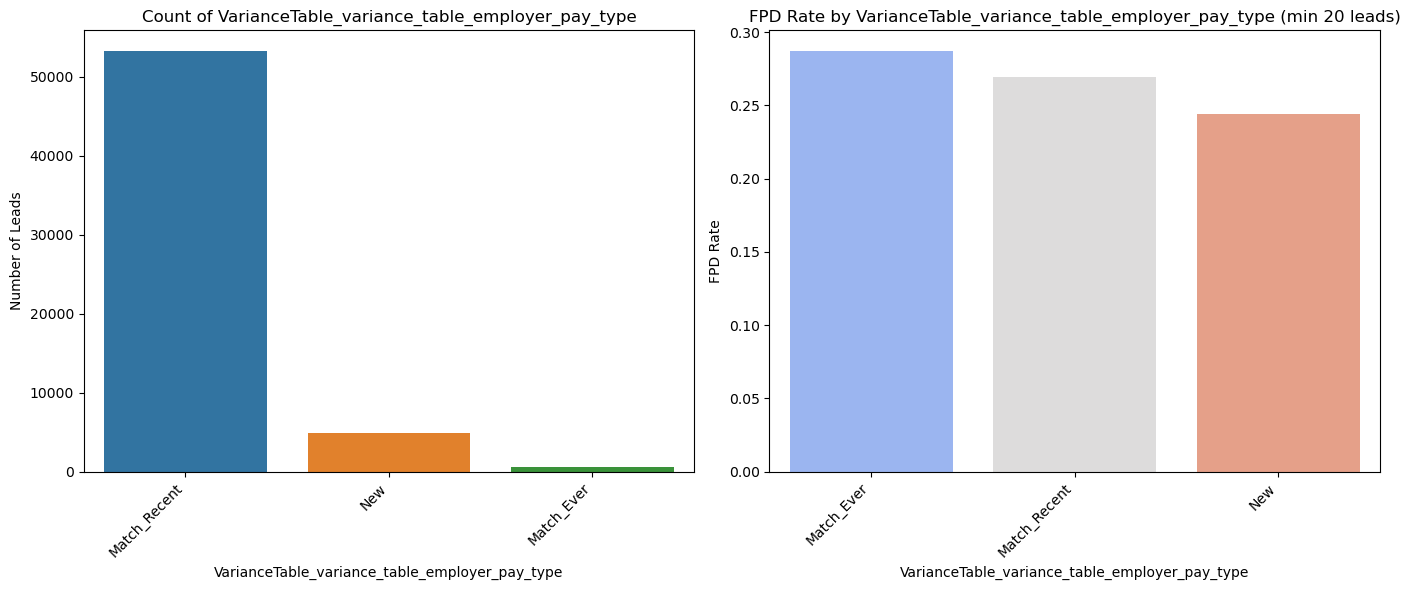


 VarianceTable_variance_table_ip_ip


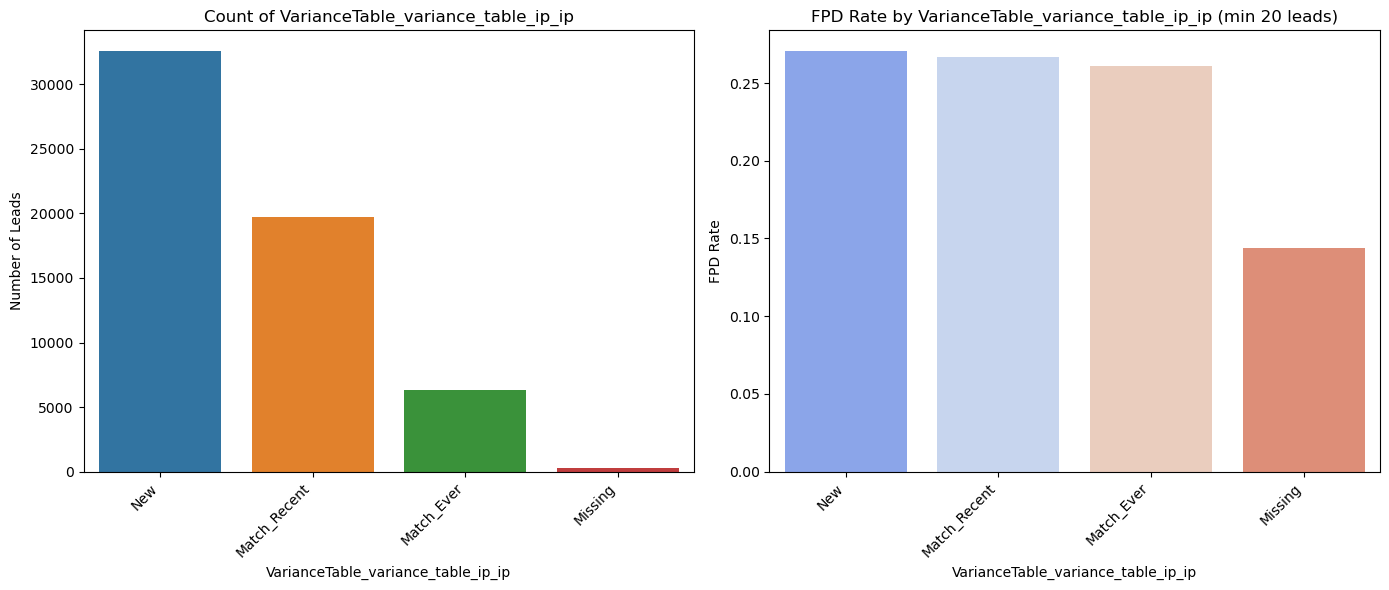


 VarianceTable_variance_table_name_last_name


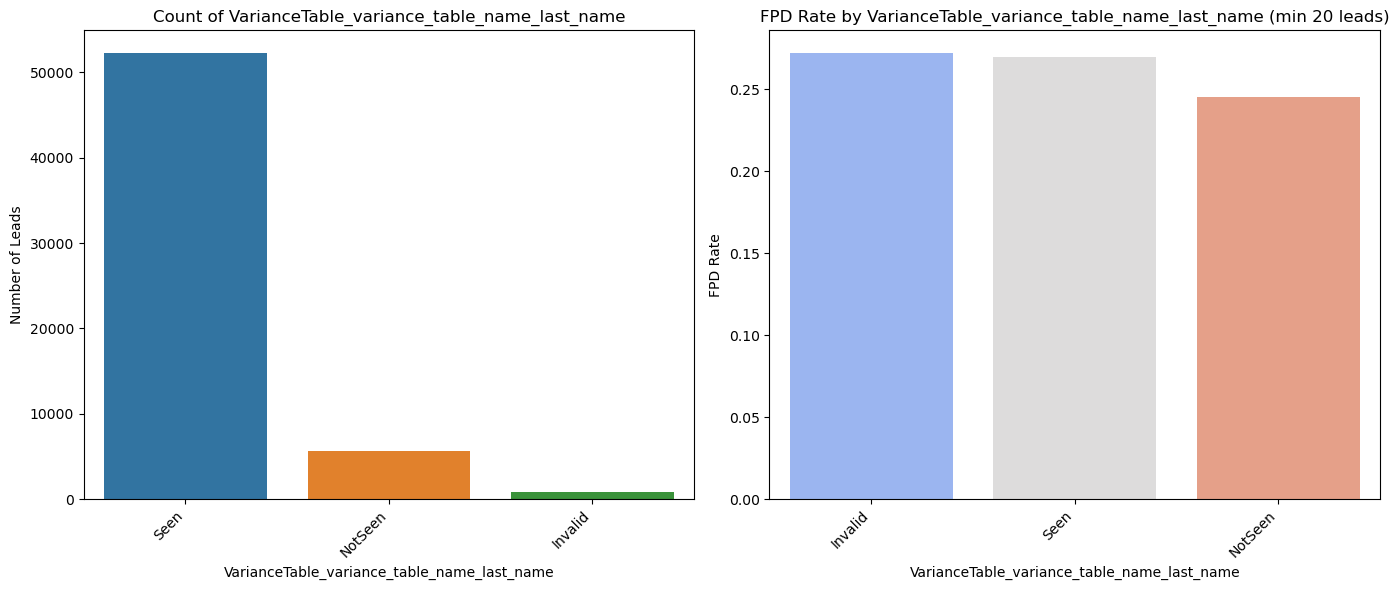


 VarianceTable_variance_table_name_first_name


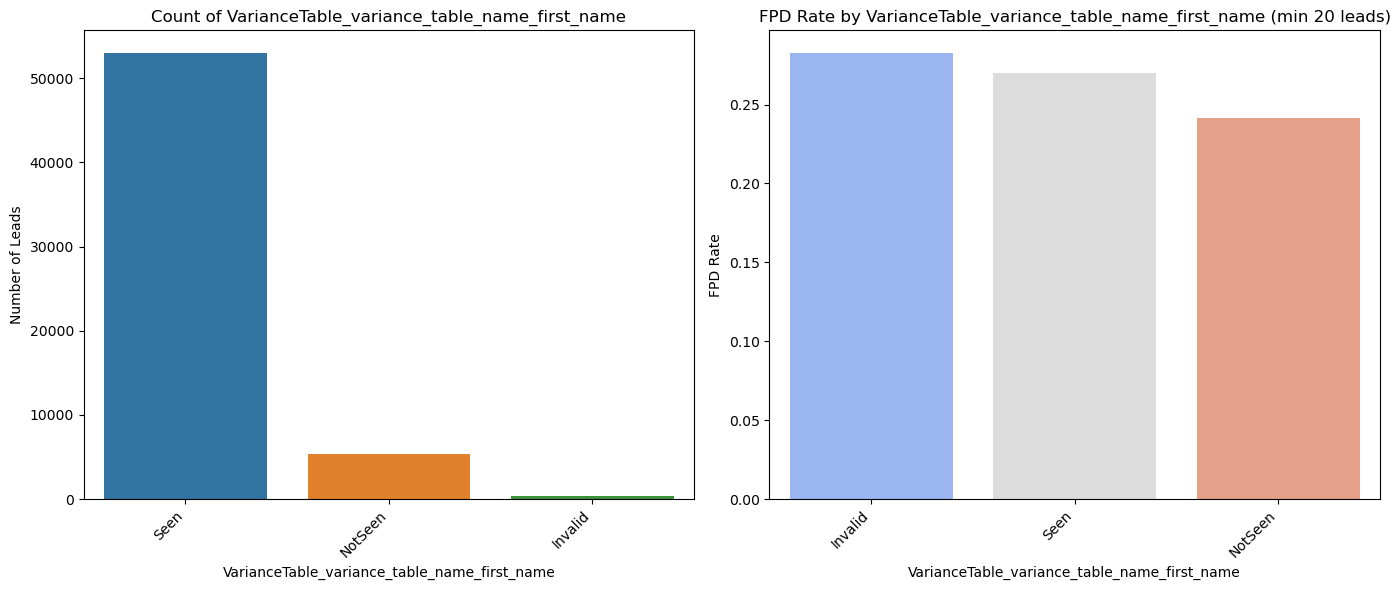


 VarianceTable_variance_table_phone_npa_npx


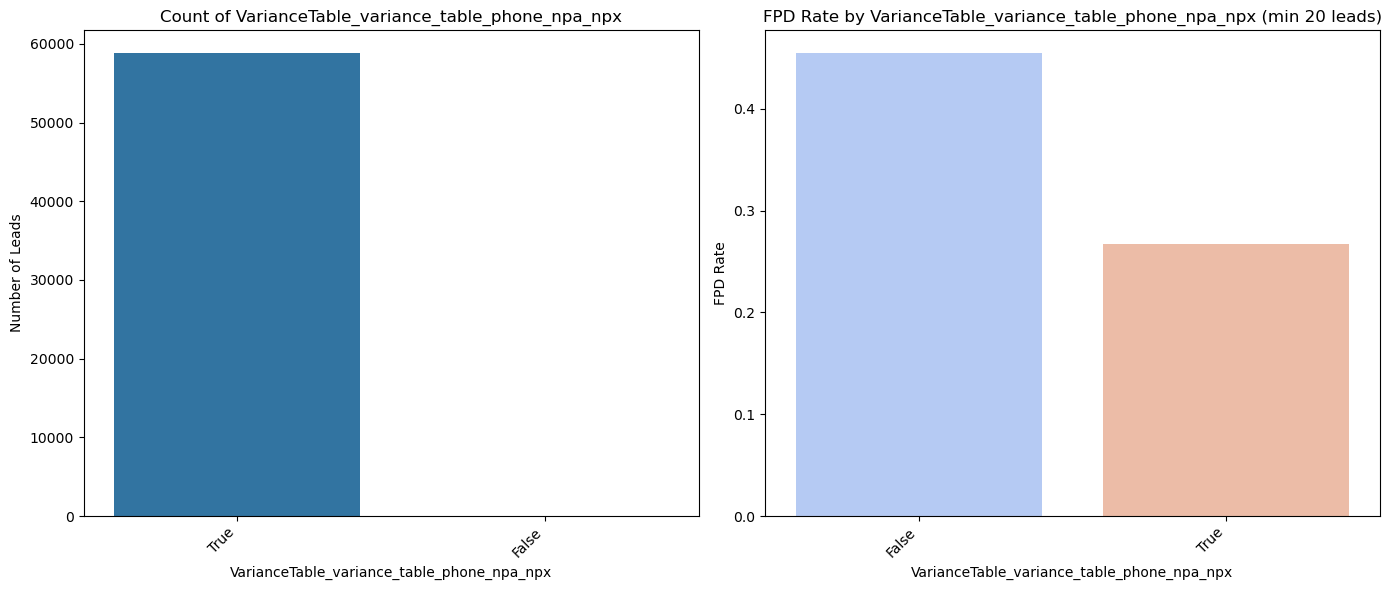


 VarianceTable_variance_table_phone_home_phone


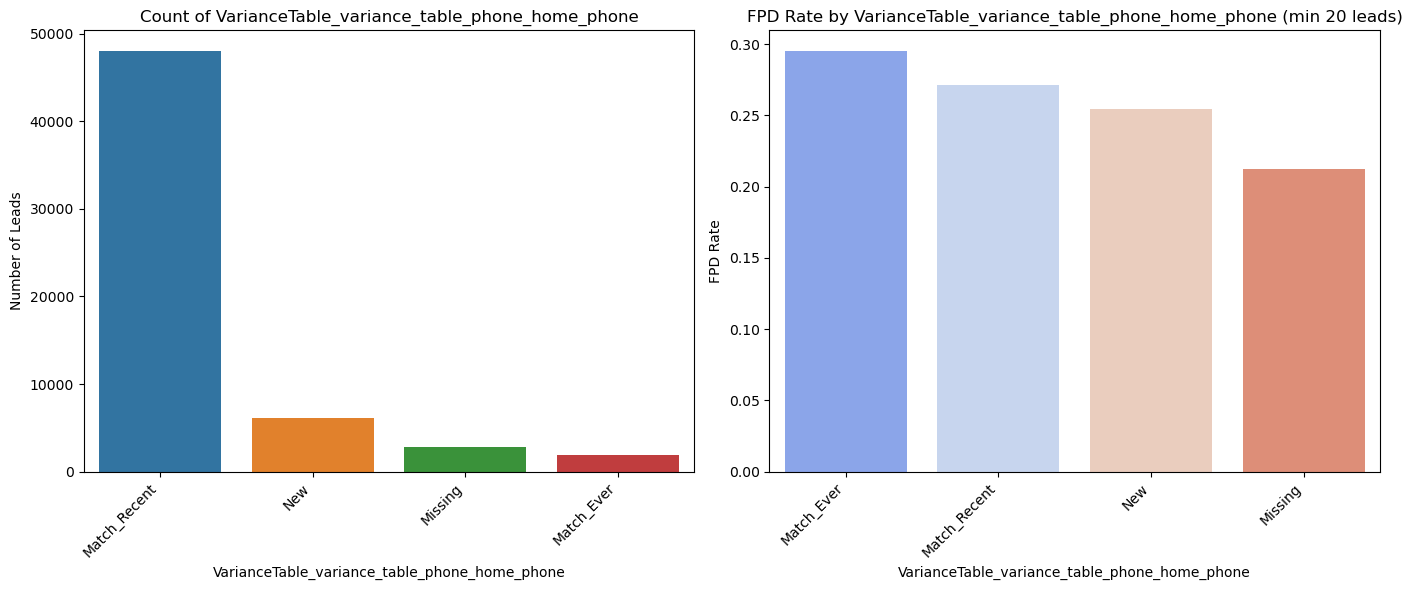


 VarianceTable_variance_table_phone_cell_phone


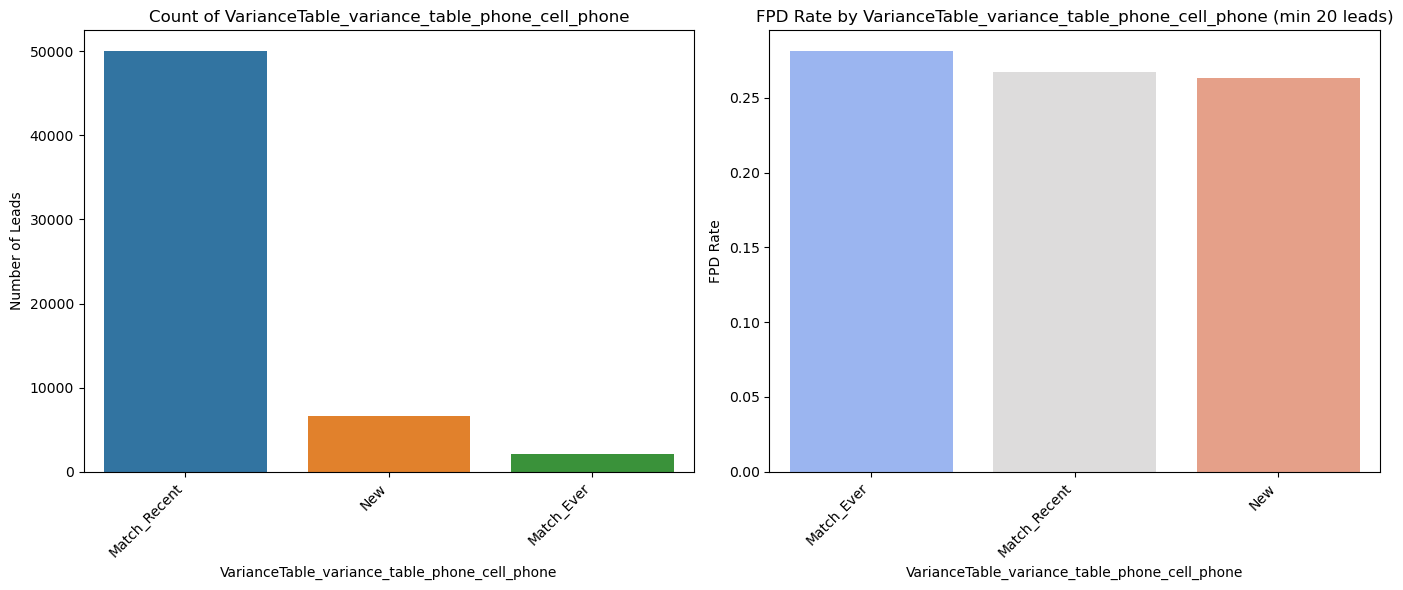


 VarianceTable_variance_table_ssn_ssn


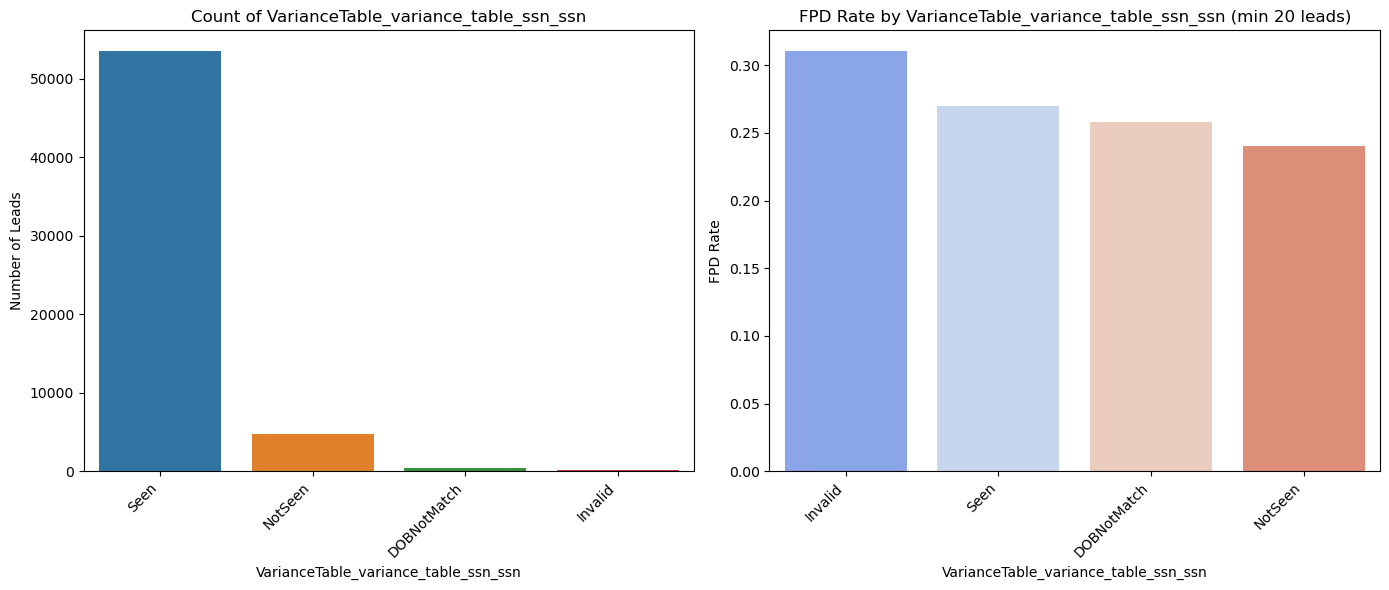


 VarianceTable_variance_table_phone_work_phone


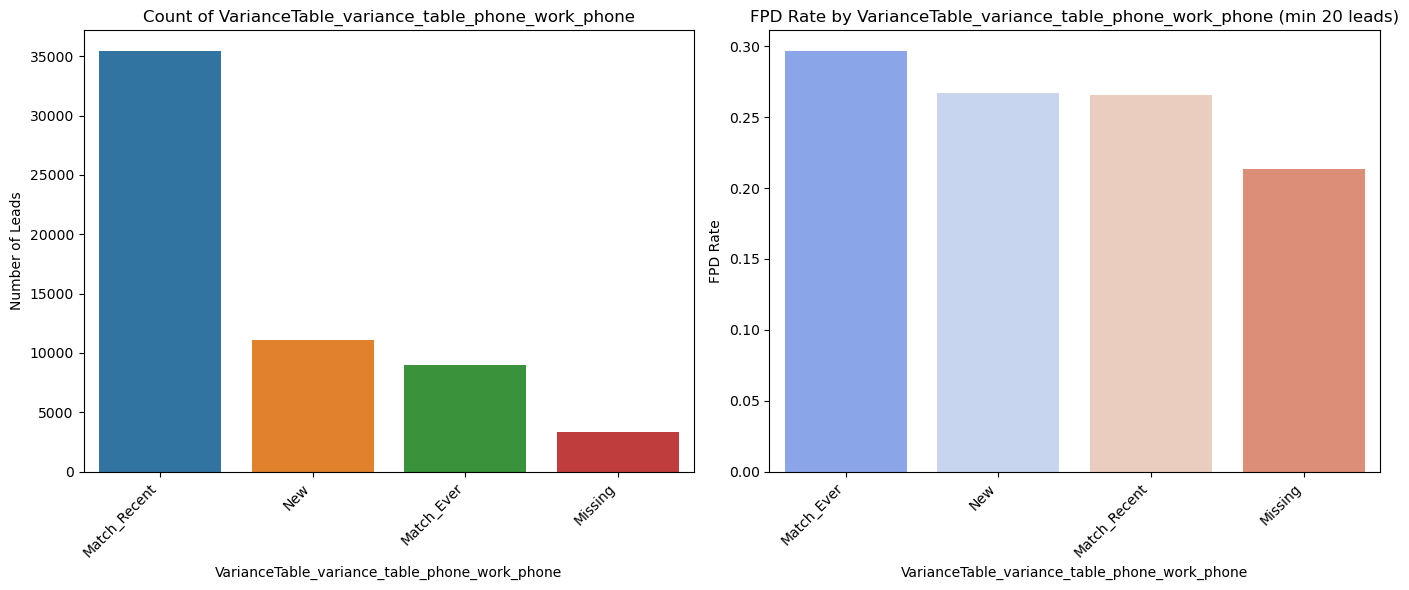


 PricingTool_predictions_min


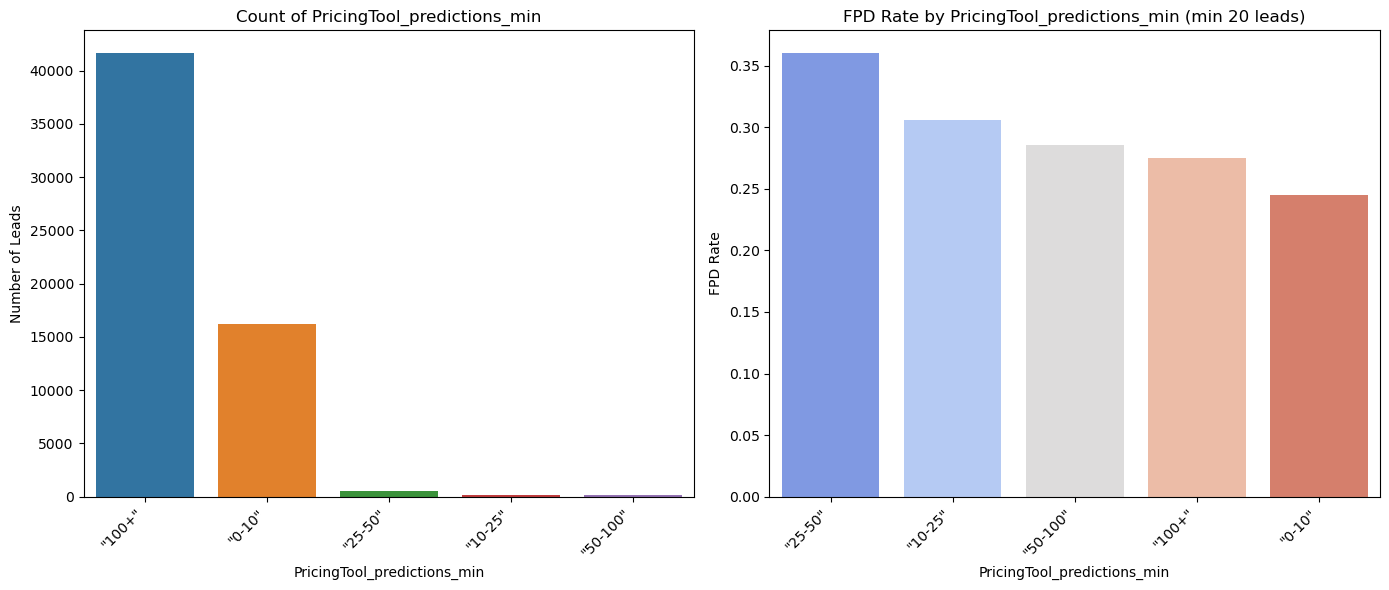


 PricingTool_predictions_max


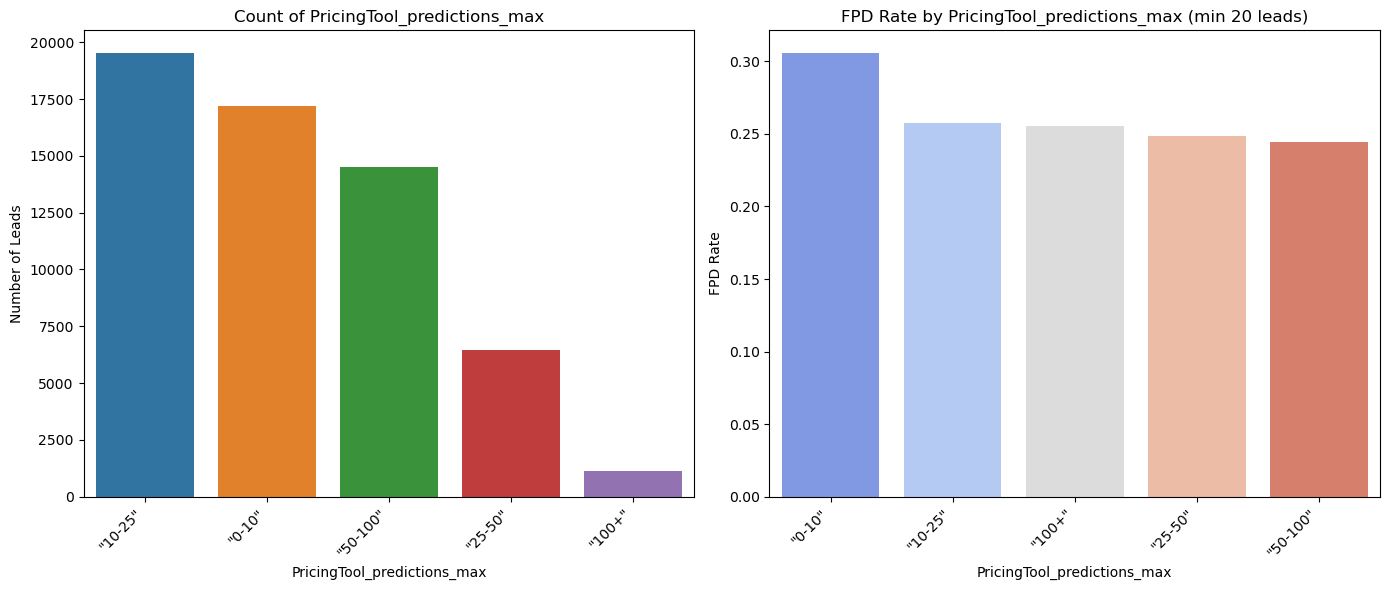


 PricingTool_predictions_ranked


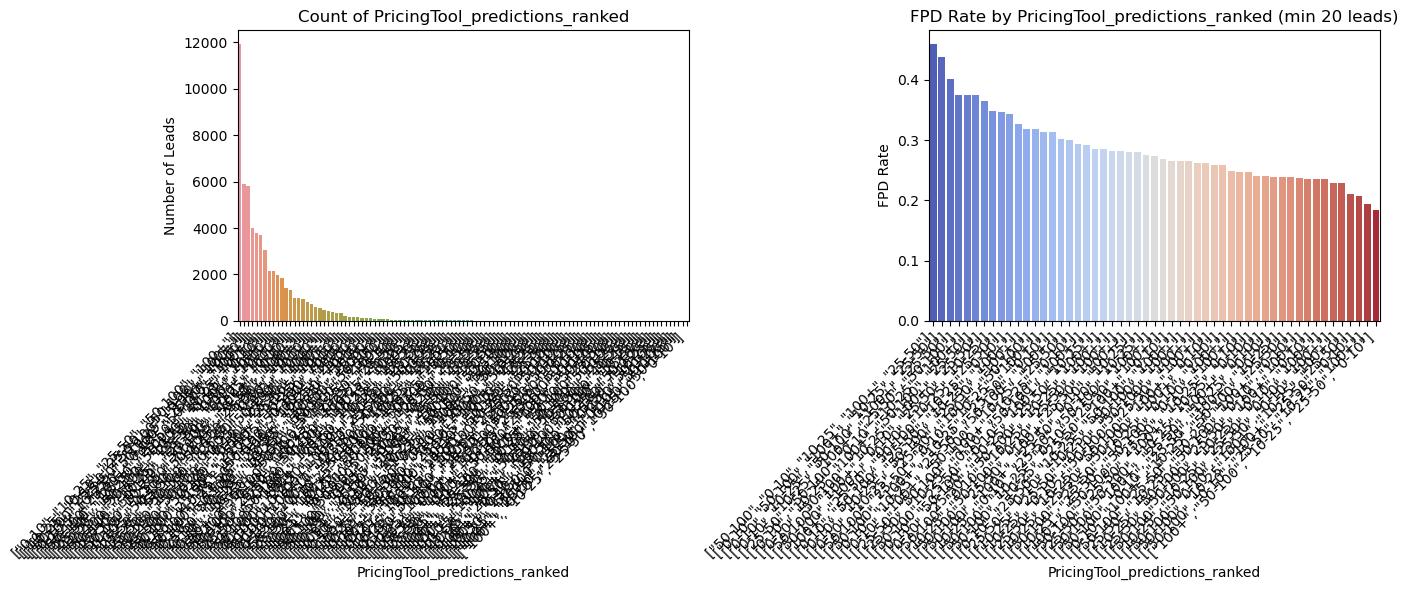


 PricingTool_predictions_min_max


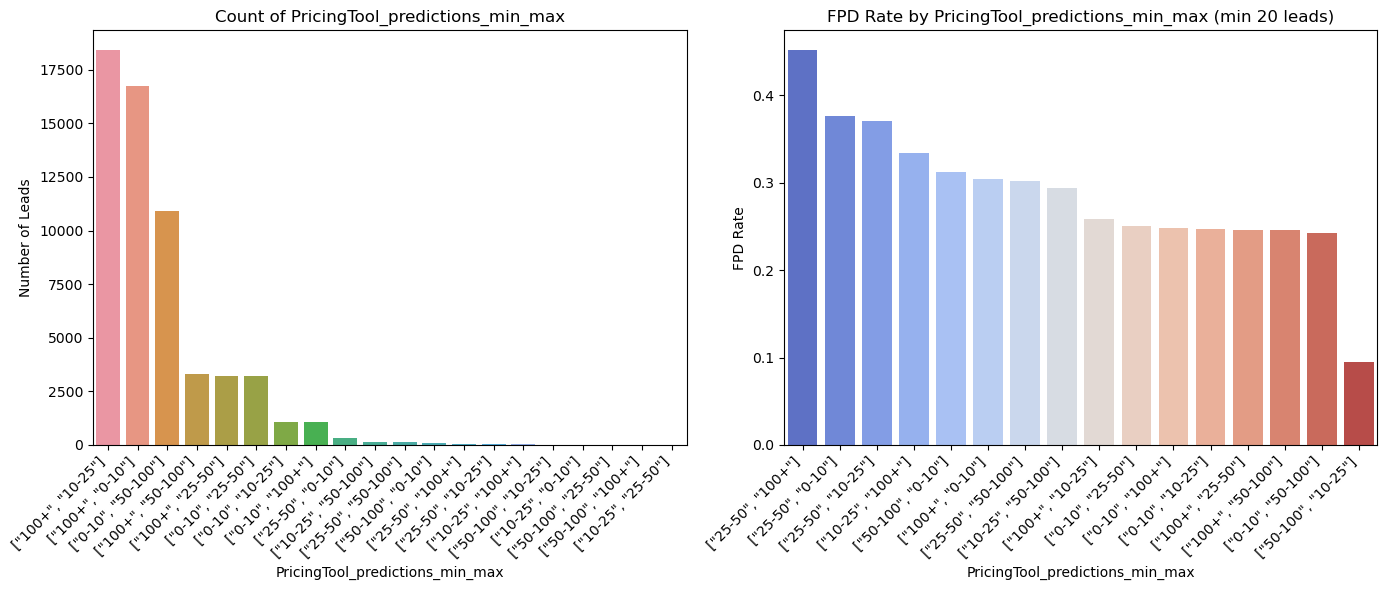


 email_ext_grouped


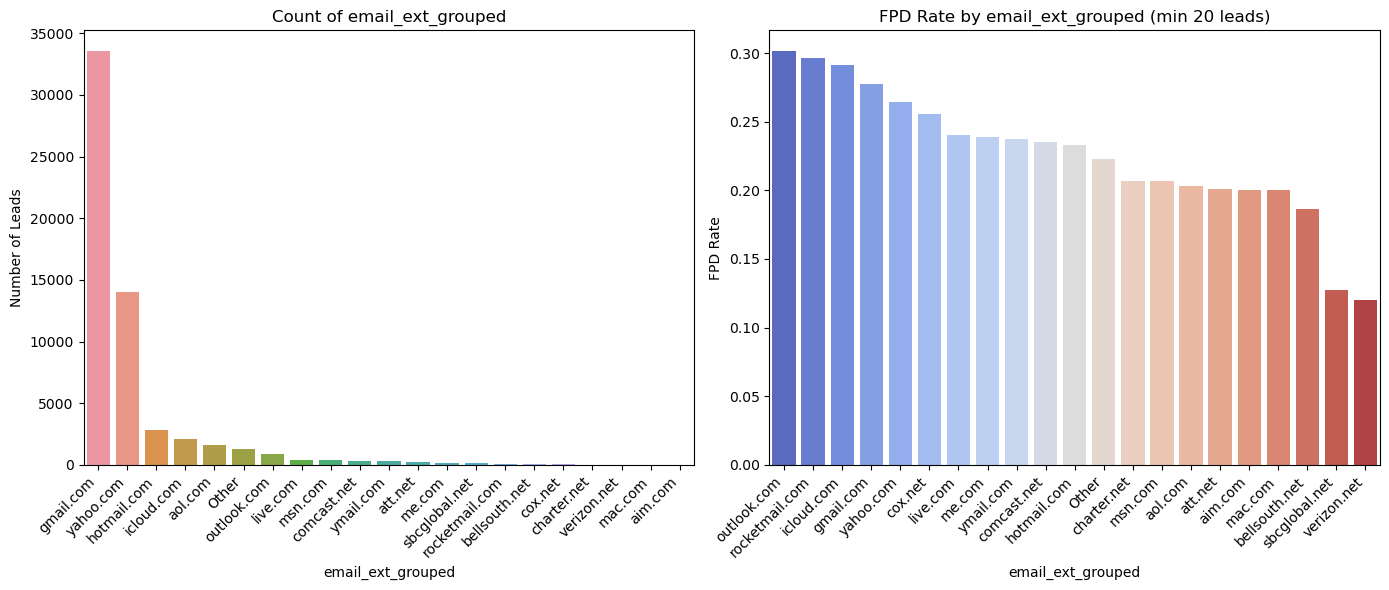


 lead_month


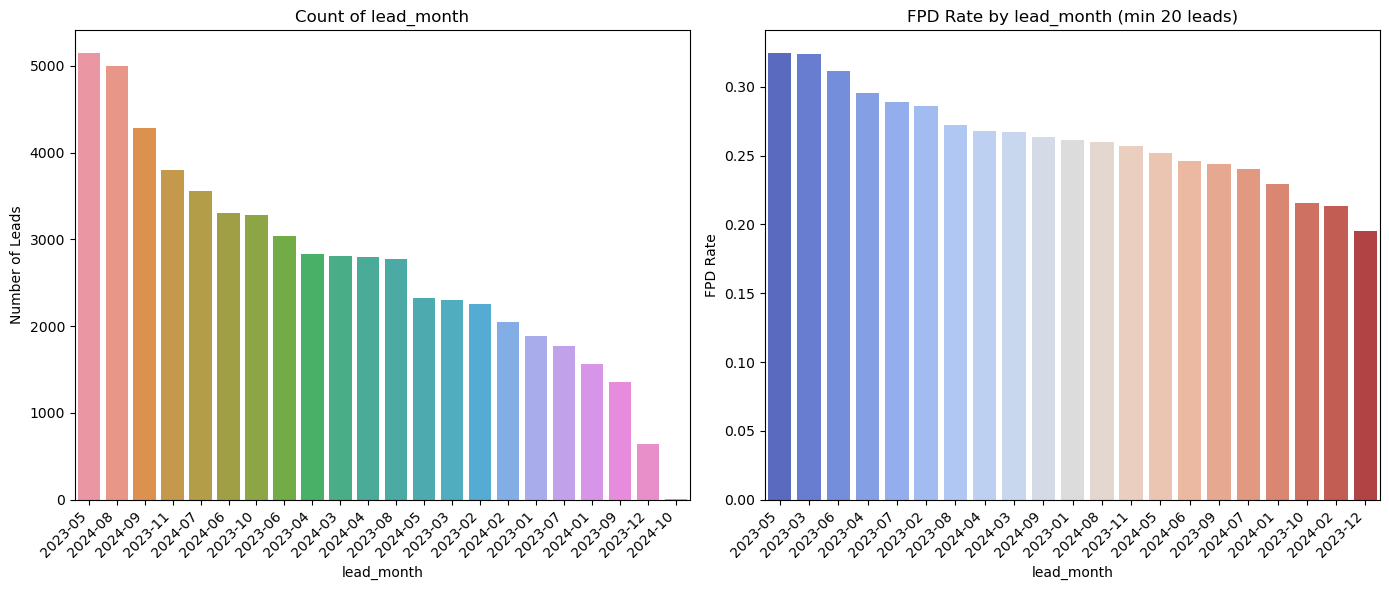


 lead_month_str


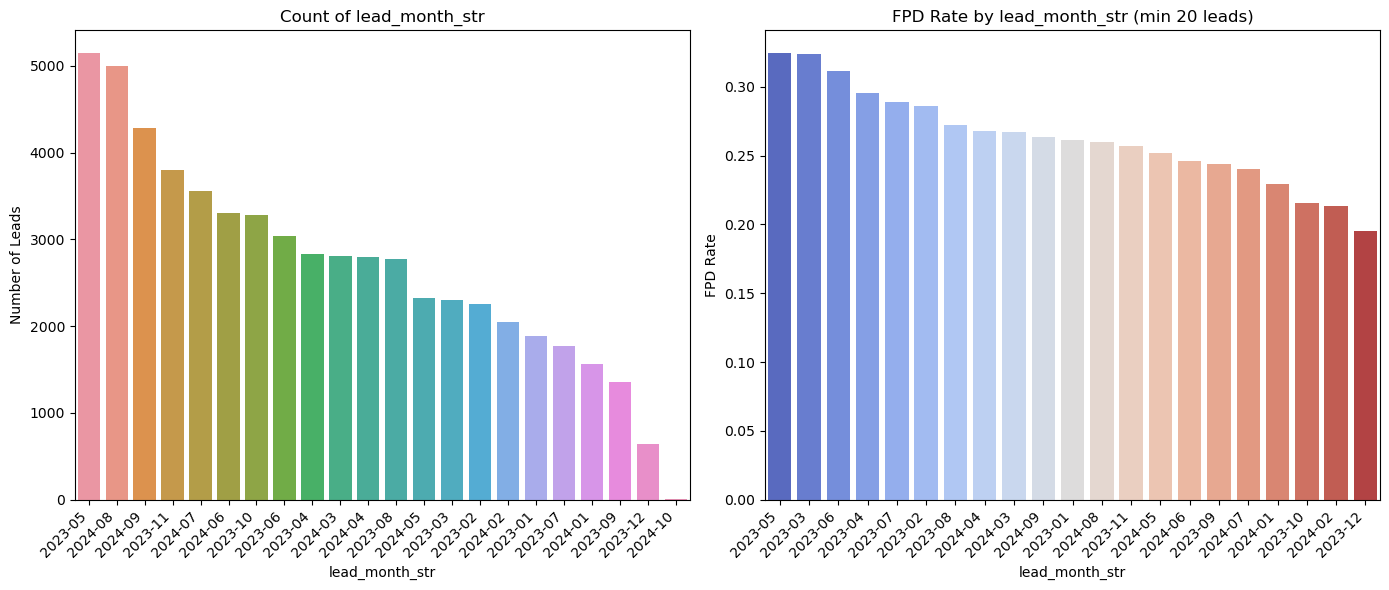

In [19]:
# distribution of fpd among categories. For eg - Snapchat as a device browser can be flagged for suspicious activity.
df_cat = df.select_dtypes(exclude = np.number)
categorical_columns = df_cat.columns
for col in categorical_columns:
    if col=='lead_datetime':
        continue

    print(f"\n {col}")

    plot_count_and_fpd(df, col)



## FEATURE ENGINEERING

In [224]:
#TRIED EXPERIMENTING WITH VELOCITY STYLE FEATURES USING ROLLING AGGREGATES


eps = 1.e-6

day_count_cols = sorted([col for col in df.columns if '_count_' in col and '_days' in col])

for col in day_count_cols:
   
    window = int(col.split('_days')[0].split('_')[-1])
    base = col.split('count_')[0]
    all_count_cols = [i for i in day_count_cols if base in i]
    for a, b in combinations(df[all_count_cols].columns,2):
        df[f'{a}/{b}'] = df[a].div(df[b]+eps)
    
    rolling_mean = df[col].rolling(window).mean().shift(1)  # shift to exclude current row
    
    # Velocity feature = current value / rolling mean
    df[f'{col}_velocity'] = df[col] / (rolling_mean+eps)
    df[f'{col}_velocity'] = df[f'{col}_velocity'].fillna(0)



DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [225]:
df = df.copy()

In [226]:
df

lead_datetime  \
lucid_id                 
1           2024-09-20   
2           2024-09-23   
3           2024-09-18   
4           2024-09-20   
5           2024-09-17   
...                ...   
58797       2023-01-01   
58798       2023-01-03   
58799       2023-01-07   
58800       2023-01-07   
58801       2023-01-09   

          VarianceTable_cross_variance_table_bank_account_ssn_count_1_day  \
lucid_id                                                                    
1                                                         1                 
2                                                         0                 
3                                                         1                 
4                                                         1                 
5                                                         0                 
...                                                     ...                 
58797                                                     0                 
58798                                                     0                 
58799                                                     1                 
58800                                                     0                 
58801                                                     0                 

          VarianceTable_cross_variance_table_bank_account_ssn_count_7_days  \
lucid_id                                                                     
1                                                         1                  
2                                                         0                  
3                                                         1                  
4                                                         1                  
5                                                         0                  
...                                                     ...                  
58797                                                     0                  
58798                                                     0                  
58799                                                     1                  
58800                                                     0                  
58801                                                     1                  

          VarianceTable_cross_variance_table_bank_account_ssn_count_30_days  \
lucid_id                                                                      
1                                                         1                   
2                                                         0                   
3                                                         1                   
4                                                         1                   
5                                                         0                   
...                                                     ...                   
58797                                                     0                   
58798                                                     0                   
58799                                                     1                   
58800                                                     0                   
58801                                                     1                   

          VarianceTable_cross_variance_table_bank_account_ssn_count_90_days  \
lucid_id                                                                      
1                                                         1                   
2                                                         0                   
3                                                         1                   
4                                                         1                   
5                                                         0                   
...                                                     ...             

In [227]:
#RATIOED SCALES -  Scale between number of applications tied to a SSN was given over multiple time windows.
#Ratios were averaged to generate new aggreagate level features depicting short term, mid term and long term bahvoiural patterns:

#Short-term: e.g., 6 hours to 24 hours

#Mid-term: e.g., 7 days to 30 days

#Long-term: 90 days to 365 days
#These provide a aggregated proxies of behavioral variance across time.
scale_cols = [col for col in df.columns if 'scale_scale_between' in col]
short_term  = [col for col in scale_cols if '24_hours_and_60_minutes' in col or '6_hours_and_60_minutes' in col]
mid_term    = [col for col in scale_cols if '7_days_and_24_hours' in col or '30_days_and_7_days' in col]
long_term   = [col for col in scale_cols if '90_days_and_30_days' in col or 
               '365_days_and_90_days' in col or 'all_time' in col]
df['scale_mean_short_term'] = df[short_term].mean(axis=1)
df['scale_mean_mid_term']   = df[mid_term].mean(axis=1)
df['scale_mean_long_term']  = df[long_term].mean(axis=1)


In [228]:
df = df.copy()

In [22]:
corr = df.corr(numeric_only=True)['ln_fpd'].sort_values(key=abs, ascending=False)
print(corr.head(50))

ln_fpd                                                                  1.000000
VarianceTable_variance_table_bank_aba_score                            -0.083035
PricingTool_predictions_ranked_TE                                       0.069222
PricingTool_predictions_25_50                                          -0.060944
PricingTool_predictions_min_max_TE                                      0.059546
PricingTool_basic_5__probability                                       -0.058604
VarianceTable_variance_table_device_parent_TE                           0.058456
PricingTool_predictions_max_TE                                          0.056657
PricingTool_predictions_50_100                                         -0.055707
lb_months_at_address_missing                                           -0.053070
email_ext_grouped_TE                                                    0.047682
VarianceTable_ssn_variance_table_zip_code_count_all_time                0.047200
VarianceTable_ssn_variance_t

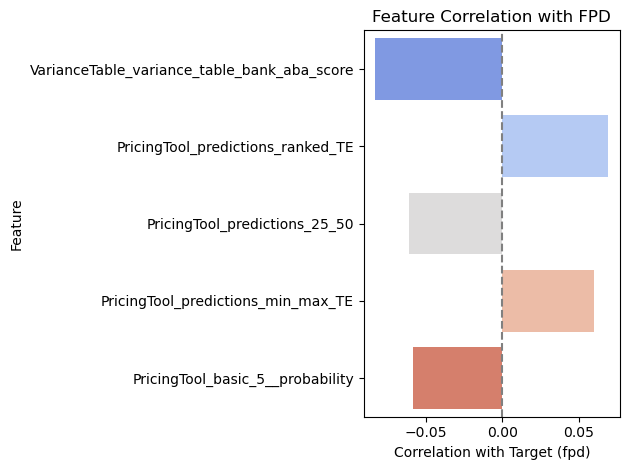

In [143]:
corr_top = corr.drop('ln_fpd').head(5)
sns.barplot(x=corr_top.values, y=corr_top.index, palette='coolwarm')
plt.title("Feature Correlation with FPD")
plt.xlabel("Correlation with Target (fpd)")
plt.ylabel("Feature")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


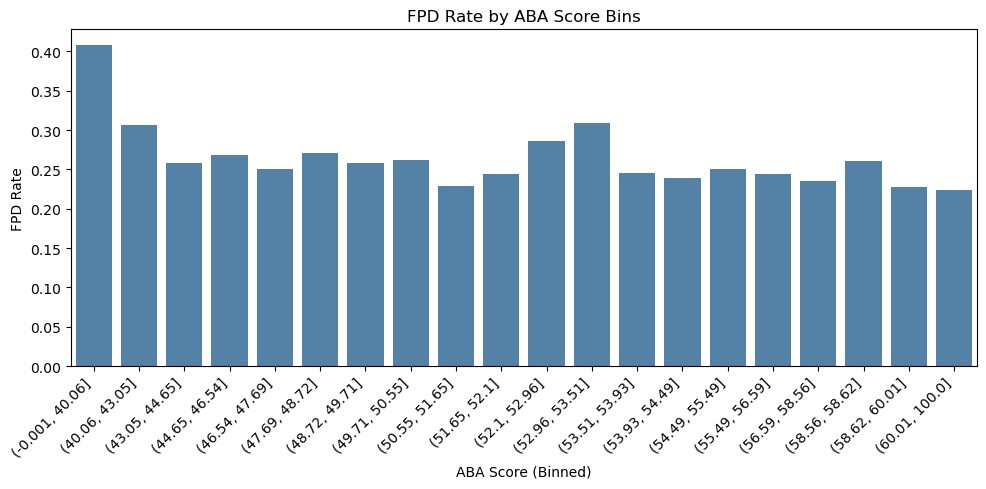

In [161]:
num_bins = 20  


df['aba_score_bin'] = pd.qcut(df['VarianceTable_variance_table_bank_aba_score'], q=num_bins, duplicates='drop')


fpd_rate_by_bin = df.groupby('aba_score_bin')['ln_fpd'].mean().reset_index()
fpd_rate_by_bin.columns = ['aba_score_bin', 'fpd_rate']


plt.figure(figsize=(10, 5))
sns.barplot(data=fpd_rate_by_bin, x='aba_score_bin', y='fpd_rate', color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.title('FPD Rate by ABA Score Bins')
plt.xlabel('ABA Score (Binned)')
plt.ylabel('FPD Rate')
plt.tight_layout()
plt.show()
df = df.drop('aba_score_bin',axis=1)

In [23]:
df

lead_datetime  \
lucid_id                 
1           2024-09-20   
2           2024-09-23   
3           2024-09-18   
4           2024-09-20   
5           2024-09-17   
...                ...   
58797       2023-01-01   
58798       2023-01-03   
58799       2023-01-07   
58800       2023-01-07   
58801       2023-01-09   

          VarianceTable_cross_variance_table_bank_account_ssn_count_1_day  \
lucid_id                                                                    
1                                                         1                 
2                                                         0                 
3                                                         1                 
4                                                         1                 
5                                                         0                 
...                                                     ...                 
58797                                                     0                 
58798                                                     0                 
58799                                                     1                 
58800                                                     0                 
58801                                                     0                 

          VarianceTable_cross_variance_table_bank_account_ssn_count_7_days  \
lucid_id                                                                     
1                                                         1                  
2                                                         0                  
3                                                         1                  
4                                                         1                  
5                                                         0                  
...                                                     ...                  
58797                                                     0                  
58798                                                     0                  
58799                                                     1                  
58800                                                     0                  
58801                                                     1                  

          VarianceTable_cross_variance_table_bank_account_ssn_count_30_days  \
lucid_id                                                                      
1                                                         1                   
2                                                         0                   
3                                                         1                   
4                                                         1                   
5                                                         0                   
...                                                     ...                   
58797                                                     0                   
58798                                                     0                   
58799                                                     1                   
58800                                                     0                   
58801                                                     1                   

          VarianceTable_cross_variance_table_bank_account_ssn_count_90_days  \
lucid_id                                                                      
1                                                         1                   
2                                                         0                   
3                                                         1                   
4                                                         1                   
5                                                         0                   
...                                                     ...             

In [229]:
#Generating some time derived features. Maybe more suspicous activity happens over specific days of week (weekend?)
df['day_of_week'] = df['lead_datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6])

In [230]:
#label encoding the pricetool prediction and dropping  columns that were not offering any 'extra' information

#df["PricingTool_predictions_max_encoded"] = df["PricingTool_predictions_max"].map(label_map)
df = df.drop(['lead_datetime'],axis=1)
df = df.drop('lead_month',axis=1)
df

VarianceTable_cross_variance_table_bank_account_ssn_count_1_day  \
lucid_id                                                                    
1                                                         1                 
2                                                         0                 
3                                                         1                 
4                                                         1                 
5                                                         0                 
...                                                     ...                 
58797                                                     0                 
58798                                                     0                 
58799                                                     1                 
58800                                                     0                 
58801                                                     0                 

          VarianceTable_cross_variance_table_bank_account_ssn_count_7_days  \
lucid_id                                                                     
1                                                         1                  
2                                                         0                  
3                                                         1                  
4                                                         1                  
5                                                         0                  
...                                                     ...                  
58797                                                     0                  
58798                                                     0                  
58799                                                     1                  
58800                                                     0                  
58801                                                     1                  

          VarianceTable_cross_variance_table_bank_account_ssn_count_30_days  \
lucid_id                                                                      
1                                                         1                   
2                                                         0                   
3                                                         1                   
4                                                         1                   
5                                                         0                   
...                                                     ...                   
58797                                                     0                   
58798                                                     0                   
58799                                                     1                   
58800                                                     0                   
58801                                                     1                   

          VarianceTable_cross_variance_table_bank_account_ssn_count_90_days  \
lucid_id                                                                      
1                                                         1                   
2                                                         0                   
3                                                         1                   
4                                                         1                   
5                                                         0                   
...                                                     ...                   
58797                                                     0                   
58798                                                     0                   
58799                                                     1                   
58800                                                     0                   
58801            

In [231]:
#one hot encoding for remaining categorical
categorical_columns = df.select_dtypes(exclude = np.number).columns
numerical_columns = df.select_dtypes(include = np.number).columns
numerical_columns = [i for i in numerical_columns if i!='day_of_week']
df2 = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

## FEATURE SELECTION

In [232]:

#X = df_keep.copy()
X = df2.drop('ln_fpd',axis=1)
y = df2['ln_fpd']


In [233]:
X

VarianceTable_cross_variance_table_bank_account_ssn_count_1_day  \
lucid_id                                                                    
1                                                         1                 
2                                                         0                 
3                                                         1                 
4                                                         1                 
5                                                         0                 
...                                                     ...                 
58797                                                     0                 
58798                                                     0                 
58799                                                     1                 
58800                                                     0                 
58801                                                     0                 

          VarianceTable_cross_variance_table_bank_account_ssn_count_7_days  \
lucid_id                                                                     
1                                                         1                  
2                                                         0                  
3                                                         1                  
4                                                         1                  
5                                                         0                  
...                                                     ...                  
58797                                                     0                  
58798                                                     0                  
58799                                                     1                  
58800                                                     0                  
58801                                                     1                  

          VarianceTable_cross_variance_table_bank_account_ssn_count_30_days  \
lucid_id                                                                      
1                                                         1                   
2                                                         0                   
3                                                         1                   
4                                                         1                   
5                                                         0                   
...                                                     ...                   
58797                                                     0                   
58798                                                     0                   
58799                                                     1                   
58800                                                     0                   
58801                                                     1                   

          VarianceTable_cross_variance_table_bank_account_ssn_count_90_days  \
lucid_id                                                                      
1                                                         1                   
2                                                         0                   
3                                                         1                   
4                                                         1                   
5                                                         0                   
...                                                     ...                   
58797                                                     0                   
58798                                                     0                   
58799                                                     1                   
58800                                                     0                   
58801            

In [234]:



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,random_state=42)
X_train.columns = X_train.columns.str.replace(r'[^\w]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w]+', '_', regex=True)

In [235]:
num_filter = 100
filter_score_df_list = []
goods = X_train[y_train == 1]
bads = X_train[y_train == 0]

num_goods = len(goods)
num_bads = len(bads)
num_vars = len(bads.columns)-2

        
df_sampled = pd.concat([goods,bads])
df_sampled.sort_index(inplace=True)
filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
filter_score.columns = ['variable','filter score']   
j = 0
for column in df_sampled:
    filter_score.loc[j,'variable'] = column
    filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
    j = j+1
    if j%100 == 0:
        print(j)

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'VarianceTable_cross_variance_table_bank_account_ssn_count_1_day' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [236]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][:100]) 
print(filter_score.head(20))

                                               variable  filter score
352                   PricingTool_predictions_ranked_TE      0.068089
343                         PricingTool_projected_value      0.066046
340                       PricingTool_predictions_25_50      0.063383
353                  PricingTool_predictions_min_max_TE      0.061027
344                    PricingTool_basic_5__probability      0.059833
354                      PricingTool_predictions_max_TE      0.057859
341                      PricingTool_predictions_50_100      0.056106
322         VarianceTable_variance_table_bank_aba_score      0.054566
350       VarianceTable_variance_table_device_parent_TE      0.054222
1271         PricingTool_predictions_min_max__100_0_10_      0.053838
137   VarianceTable_cross_variance_table_driver_lice...      0.048650
342                        PricingTool_predictions_100_      0.046283
237   VarianceTable_ssn_variance_table_cell_phone_co...      0.046269
345                 

In [237]:
filter_score_df_list = []
df_top = X_train.filter(vars_keep, axis=1)
filter_score_df_list.append(filter_score)
filter_score = pd.concat(filter_score_df_list)
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)
filter_score

variable  filter score
0                     PricingTool_predictions_ranked_TE      0.068089
1                           PricingTool_projected_value      0.066046
2                         PricingTool_predictions_25_50      0.063383
3                    PricingTool_predictions_min_max_TE      0.061027
4                      PricingTool_basic_5__probability      0.059833
...                                                 ...           ...
1300  PricingTool_predictions_ranked__25_50_100_50_1...      0.000002
1301  PricingTool_predictions_ranked__100_10_25_0_10...      0.000000
1302  PricingTool_predictions_ranked__100_25_50_0_10...      0.000000
1303  PricingTool_predictions_ranked__10_25_100_25_5...      0.000000
1304  VarianceTable_variance_table_device_browser_Fa...      0.000000

[1305 rows x 2 columns]

In [238]:
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

PricingTool_predictions_ranked_TE  PricingTool_projected_value  \
lucid_id                                                                   
42093                              0.248215                       9.7526   
26352                              0.297637                       1.8988   
5149                               0.248215                       8.5149   
39549                              0.297637                       1.9242   
50560                              0.272245                       4.3490   

          PricingTool_predictions_25_50  PricingTool_predictions_min_max_TE  \
lucid_id                                                                      
42093                            0.2969                            0.258733   
26352                            0.0553                            0.300781   
5149                             0.2181                            0.258733   
39549                            0.0456                            0.300781   
50560                            0.1757                            0.258733   

          PricingTool_basic_5__probability  PricingTool_predictions_max_TE  \
lucid_id                                                                     
42093                               0.4393                        0.257068   
26352                               0.0495                        0.301768   
5149                                0.4743                        0.257068   
39549                               0.0632                        0.301768   
50560                               0.2310                        0.257068   

          PricingTool_predictions_50_100  \
lucid_id                                   
42093                             0.2063   
26352                             0.0261   
5149                              0.2108   
39549                             0.0104   
50560                             0.0895   

          VarianceTable_variance_table_bank_aba_score  \
lucid_id                                                
42093                                           53.51   
26352                                           51.65   
5149                                            56.45   
39549                                           47.17   
50560                                           58.45   

          VarianceTable_variance_table_device_parent_TE  \
lucid_id                                                  
42093                                          0.275633   
26352                                          0.251621   
5149                                           0.275633   
39549                                          0.252140   
50560                                          0.407481   

          PricingTool_predictions_min_max__100_0_10_  ...  \
lucid_id                                              ...   
42093                                          False  ...   
26352                                           True  ...   
5149                                           False  ...   
39549                                           True  ...   
50560                                          False  ...   

          VarianceTable_variance_table_device_device_type_Missing  \
lucid_id                                                            
42093                                                 False         
26352                                                 False         
5149                                                  False         
39549                                                 False         
50560                                                 False         

          VarianceTable_variance_table_device_is_tablet_Missing  \
lucid_id                                                          
42093                                                 False       
26352                                                 False       
5149                                                  False       
39549 

In [239]:
X_train_filtered = df_keep
y_train_filtered = y_train

In [243]:


import warnings
warnings.filterwarnings("ignore")

# Classifiers
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
nthreads = 1
warnings.filterwarnings("ignore") 


nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=40,forward=True,verbose=1,cv=3,scoring='roc_auc',n_jobs=-1)
#sfs = SFS(clf,k_features=1,forward=False,verbose=1,scoring='roc_auc',cv=4,n_jobs=-1)
sfs.fit(X_train_filtered,y_train_filtered)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/rujhan98/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rujhan98/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rujhan98/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rujhan98/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rujhan98/anaconda

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   53.2s finished
Features: 29/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  1.0min finished
Features: 30/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.1min finished
Features: 31/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:  1.7min finished
Features: 32/40[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:  1.4min finished
Features: 33/40[Parallel(n_jobs=-

SequentialFeatureSelector(cv=3,
                          estimator=RandomForestClassifier(n_estimators=5),
                          k_features=(40, 40), n_jobs=-1, scoring='roc_auc',
                          verbose=1)

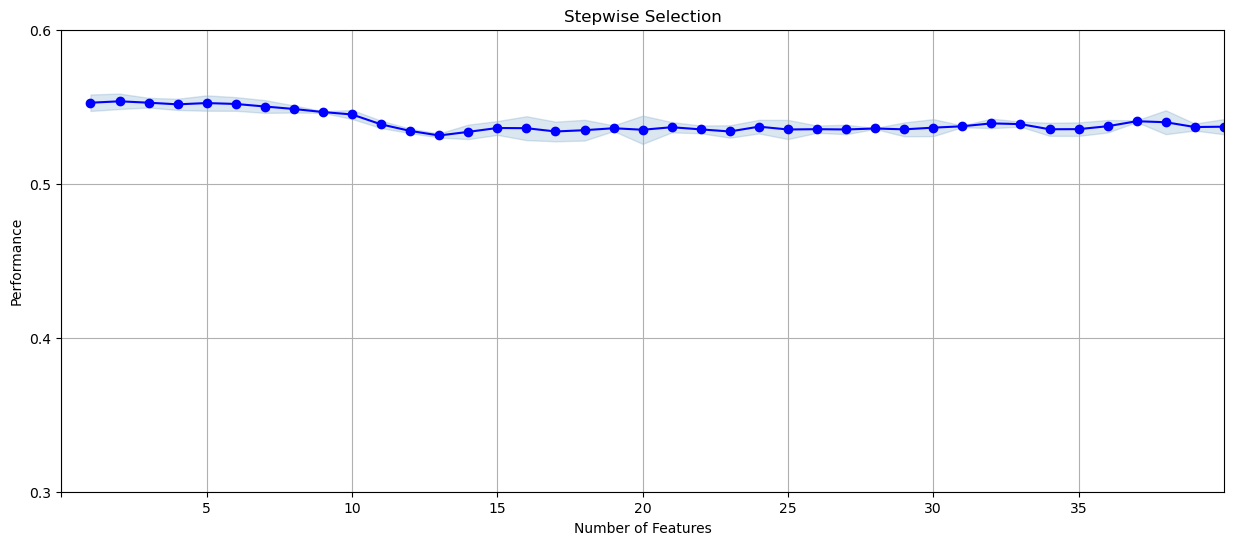

In [246]:
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, 40, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.3, .6])
plt.xlim(0,40)
plt.title('Stepwise Selection')
plt.grid()
plt.show()

In [247]:
num_vars_to_keep = 30
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]

ordered_vars_FS

feature_idx  \
1                                                (7,)   
2                                             (7, 90)   
3                                         (7, 90, 92)   
4                                     (7, 89, 90, 92)   
5                                 (7, 87, 89, 90, 92)   
6                             (7, 87, 88, 89, 90, 92)   
7                         (7, 87, 88, 89, 90, 91, 92)   
8                     (7, 44, 87, 88, 89, 90, 91, 92)   
9                 (7, 13, 44, 87, 88, 89, 90, 91, 92)   
10            (7, 13, 27, 44, 87, 88, 89, 90, 91, 92)   
11        (7, 13, 27, 44, 50, 87, 88, 89, 90, 91, 92)   
12    (7, 13, 27, 36, 44, 50, 87, 88, 89, 90, 91, 92)   
13  (7, 13, 27, 33, 36, 44, 50, 87, 88, 89, 90, 91...   
14  (7, 13, 27, 33, 36, 44, 50, 59, 87, 88, 89, 90...   
15  (7, 13, 27, 33, 36, 44, 50, 59, 65, 87, 88, 89...   
16  (7, 13, 27, 33, 36, 44, 50, 58, 59, 65, 87, 88...   
17  (7, 13, 25, 27, 33, 36, 44, 50, 58, 59, 65, 87...   
18  (7, 13, 25, 27, 33, 36, 44, 50, 58, 59, 65, 73...   
19  (7, 13, 22, 25, 27, 33, 36, 44, 50, 58, 59, 65...   
20  (7, 13, 22, 25, 27, 33, 36, 44, 50, 54, 58, 59...   
21  (7, 13, 22, 25, 27, 33, 36, 44, 49, 50, 54, 58...   
22  (6, 7, 13, 22, 25, 27, 33, 36, 44, 49, 50, 54,...   
23  (6, 7, 13, 22, 25, 27, 33, 36, 43, 44, 49, 50,...   
24  (6, 7, 13, 22, 25, 27, 33, 36, 43, 44, 49, 50,...   
25  (6, 7, 13, 22, 25, 27, 33, 36, 43, 44, 49, 50,...   
26  (6, 7, 13, 22, 25, 27, 33, 36, 43, 44, 49, 50,...   
27  (6, 7, 13, 16, 22, 25, 27, 33, 36, 43, 44, 49,...   
28  (6, 7, 8, 13, 16, 22, 25, 27, 33, 36, 43, 44, ...   
29  (6, 7, 8, 13, 16, 22, 25, 27, 33, 36, 43, 44, ...   
30  (6, 7, 8, 13, 16, 17, 22, 25, 27, 33, 36, 43, ...   
31  (6, 7, 8, 13, 16, 17, 22, 25, 27, 33, 36, 42, ...   
32  (6, 7, 8, 13, 16, 17, 22, 25, 27, 33, 36, 41, ...   
33  (6, 7, 8, 13, 16, 17, 18, 22, 25, 27, 33, 36, ...   
34  (6, 7, 8, 13, 16, 17, 18, 22, 25, 27, 33, 36, ...   
35  (0, 6, 7, 8, 13, 16, 17, 18, 22, 25, 27, 33, 3...   
36  (0, 6, 7, 8, 13, 16, 17, 18, 22, 25, 27, 33, 3...   
37  (0, 6, 7, 8, 13, 16, 17, 18, 22, 25, 27, 33, 3...   
38  (0, 6, 7, 8, 13, 16, 17, 18, 22, 23, 25, 27, 3...   
39  (0, 6, 7, 8, 13, 16, 17, 18, 22, 23, 25, 27, 2...   
40  (0, 6, 7, 8, 13, 16, 17, 18, 22, 23, 25, 27, 2...   

                                            cv_scores avg_score  \
1   [0.5458901981816258, 0.5528821333352706, 0.559...  0.552594   
2   [0.5494269120422408, 0.5505693309538912, 0.560...  0.553521   
3   [0.548421620340015, 0.5533998363074056, 0.5560...  0.552615   
4   [0.5469610927461042, 0.5517448024158604, 0.555...  0.551542   
5   [0.5469075371766717, 0.5512415342972528, 0.558...  0.552378   
6   [0.5463400270206278, 0.5518156755136009, 0.557...  0.551791   
7   [0.544878212033221, 0.5505680026762896, 0.5549...  0.550144   
8   [0.5468350772501145, 0.5469469959497563, 0.551...  0.548531   
9   [0.5465518235779804, 0.5458975617675514, 0.547...  0.546547   
10  [0.5410561033618153, 0.5480345706745202, 0.545...  0.544972   
11  [0.5413659857520503, 0.5387741309750569, 0.535...  0.538545   
12  [0.533413647715367, 0.5363290294337913, 0.5331...  0.534292   
13  [0.5313152911775114, 0.5296833990699726, 0.532...   0.53132   
14  [0.5292836351742572, 0.5401996439185934, 0.531...  0.533674   
15  [0.5351198777458612, 0.542135635630575, 0.5313...  0.536187   
16  [0.5300068386342506, 0.547014738107436, 0.5311...   0.53606   
17  [0.528612943817389, 0.5429009132830173, 0.5302...  0.533926   
18  [0.5309185029505433, 0.5442357238417616, 0.529...   0.53476   
19  [0.5376293193542456, 0.5334497437630521, 0.537...  0.536032   
20  [0.5439539854667097, 0.5387800946704109, 0.522...  0.535044   
21  [0.5357897966666321, 0.5330846436227128, 0.541...  0.536685   
22  [0.5377983608960215, 0.5318429209269026, 0.536...  0.535289   
23  [0.5326683417417746, 0.5297442829779951, 0.539...  0.533921   
24  [0.5312438476142404, 0.5380018866421329, 0.541...  0.537058   
25  [0.5311458295389104, 0.54

In [280]:
vars_top = ordered_vars_FS['variable name']
vars_top_list = ordered_vars_FS['variable name'].tolist()


In [249]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

filter score
variable                                                        
PricingTool_projected_value                             0.066046
PricingTool_predictions_25_50                           0.063383
PricingTool_predictions_min_max_TE                      0.061027
PricingTool_basic_5__probability                        0.059833
PricingTool_predictions_max_TE                          0.057859
...                                                          ...
PricingTool_predictions_ranked__25_50_100_50_10...      0.000002
PricingTool_predictions_ranked__100_10_25_0_10_...      0.000000
PricingTool_predictions_ranked__100_25_50_0_10_...      0.000000
PricingTool_predictions_ranked__10_25_100_25_50...      0.000000
VarianceTable_variance_table_device_browser_Fac...      0.000000

[1304 rows x 1 columns]

In [283]:
vars_top_sorted = pd.DataFrame(vars_top_list)
vars_top_sorted.columns=['variable']
vars_top_sorted.set_index('variable',drop=True,inplace=True)


In [284]:
vars_top_sorted = pd.concat([vars_top_sorted,filter_score],axis=1,join='inner')

In [285]:
vars_top_sorted.reset_index(inplace=True)
vars_top_sorted.reset_index(inplace=True)
vars_top_sorted['index'] = vars_top_sorted['index'] + 1
vars_top_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_top_sorted

wrapper order                                           variable  \
0               1        VarianceTable_variance_table_bank_aba_score   
1               2  VarianceTable_variance_table_device_device_typ...   
2               3  VarianceTable_variance_table_device_is_mobile_...   
3               4  VarianceTable_variance_table_device_browser_Mi...   
4               5  VarianceTable_variance_table_device_crawler_Mi...   
5               6  VarianceTable_variance_table_device_platform_M...   
6               7  VarianceTable_variance_table_device_is_tablet_...   
7               8                     PricingTool_predictions_min_TE   
8               9                 PricingTool_basic_5_basic_worth_5_   
9              10  VarianceTable_cross_variance_table_driver_lice...   
10             11  VarianceTable_ssn_variance_table_email_count_a...   
11             12  VarianceTable_cross_variance_table_driver_lice...   
12             13  VarianceTable_ssn_variance_table_bank_account_...   
13             14  VarianceTable_ssn_variance_table_lead_count_15...   
14             15  VarianceTable_cross_variance_table_phone_bank_...   
15             16  VarianceTable_cross_variance_table_bank_accoun...   
16             17  VarianceTable_ssn_variance_table_sum_count_15_...   
17             18  VarianceTable_cross_variance_table_phone_bank_...   
18             19  VarianceTable_ssn_variance_table_multiple_coun...   
19             20  VarianceTable_cross_variance_table_email_bank_...   
20             21  VarianceTable_ssn_variance_table_work_phone_co...   
21             22                     PricingTool_predictions_50_100   
22             23  VarianceTable_cross_variance_table_bank_accoun...   
23             24  VarianceTable_ssn_variance_table_user_agent_br...   
24             25  VarianceTable_ssn_variance_table_lead_count_15...   
25             26  VarianceTable_cross_variance_table_email_bank_...   
26             27  VarianceTable_ssn_variance_table_bank_account_...   
27             28      VarianceTable_variance_table_device_parent_TE   
28             29  VarianceTable_ssn_variance_table_lead_count_7_...   
29             30  VarianceTable_cross_variance_table_driver_lice...   
30             31  VarianceTable_ssn_variance_table_zip_code_coun...   
31             32  VarianceTable_cross_variance_table_bank_accoun...   
32             33  VarianceTable_ssn_variance_table_bank_account_...   
33             34  VarianceTable_cross_variance_table_driver_lice...   
34             35  VarianceTable_ssn_variance_table_lead_count_7_...   
35             36  VarianceTable_cross_variance_table_phone_bank_...   
36             37  VarianceTable_cross_variance_table_phone_bank_...   
37             38  VarianceTable_ssn_variance_table_multiple_coun...   
38             39  VarianceTable_cross_variance_table_bank_accoun...   

    filter score  
0       0.054566  
1       0.029966  
2       0.029966  
3       0.029966  
4       0.029966  
5       0.029966  
6       0.029966  
7       0.033328  
8       0.043695  
9       0.036998  
10      0.032766  
11      0.035057  
12      0.035699  
13      0.032039  
14      0.031702  
15      0.032119  
16      0.037126  
17      0.030769  
18      0.037489  
19      0.032440  
20      0.032868  
21      0.056106  
22      0.033471  
23      0.031976  
24      0.030073  
25      0.030604  
26      0.042629  
27      0.054222  
28      0.030244  
29      0.042570  
30      0.034070  
31      0.034082  
32      0.042032  
33      0.030569  
34      0.031229  
35      0.032692  
36      0.037371  
37      0.036682  
38      0.031824

In [286]:
vars_top_list = vars_top_sorted['variable'].tolist()
vars_keep_list = vars_top_list[:num_vars_to_keep]



In [287]:
final_features = vars_keep_list

In [288]:
X_train = X_train[final_features]
X_test = X_test[final_features]

In [266]:
#simple random forest model to understand feature importances

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)


importances = rfc.feature_importances_


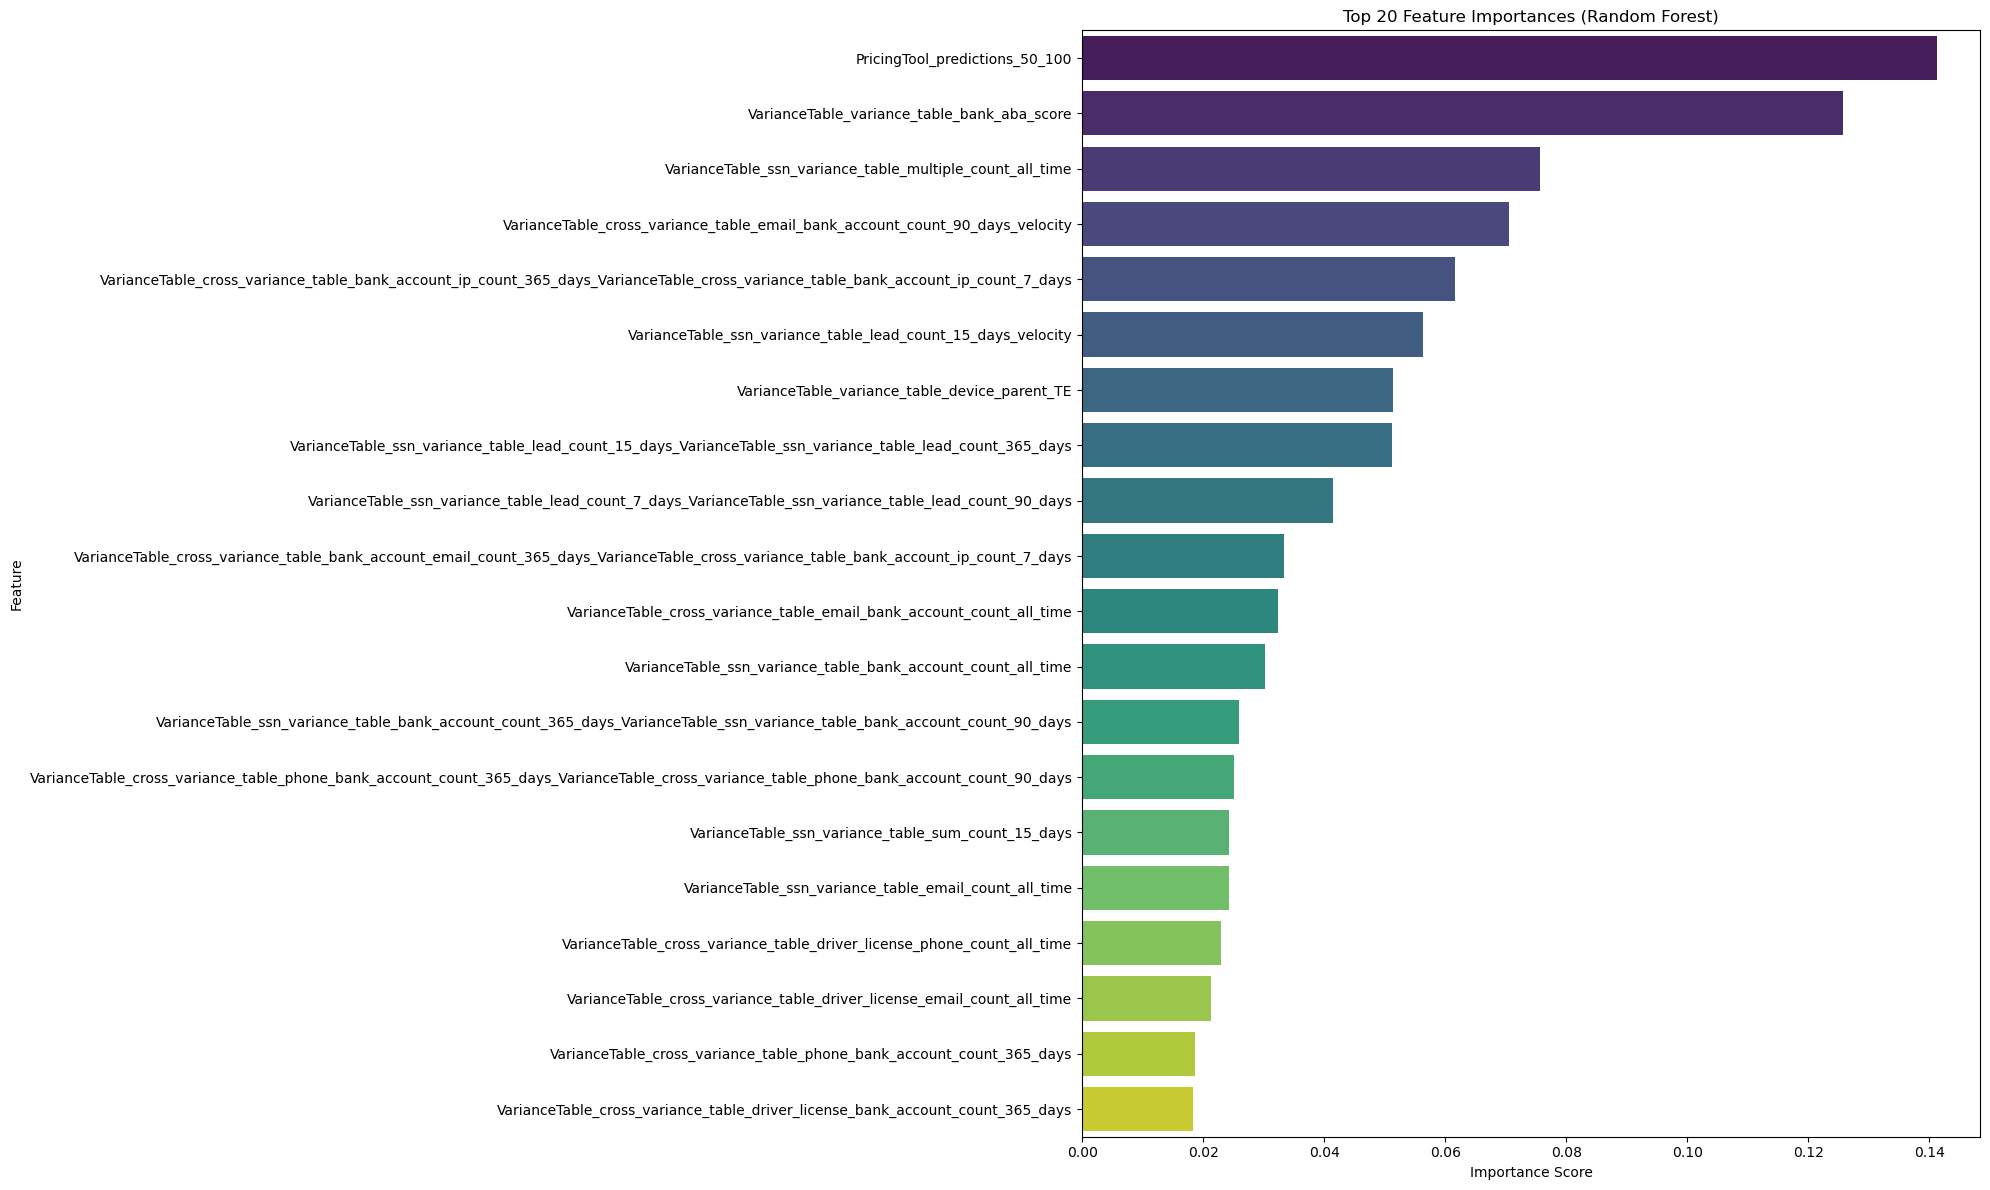

In [298]:
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(20, 12))
sns.barplot(x='importance', y='feature', data=importance_df.head(20), palette='viridis')
plt.title(f'Top {20} Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

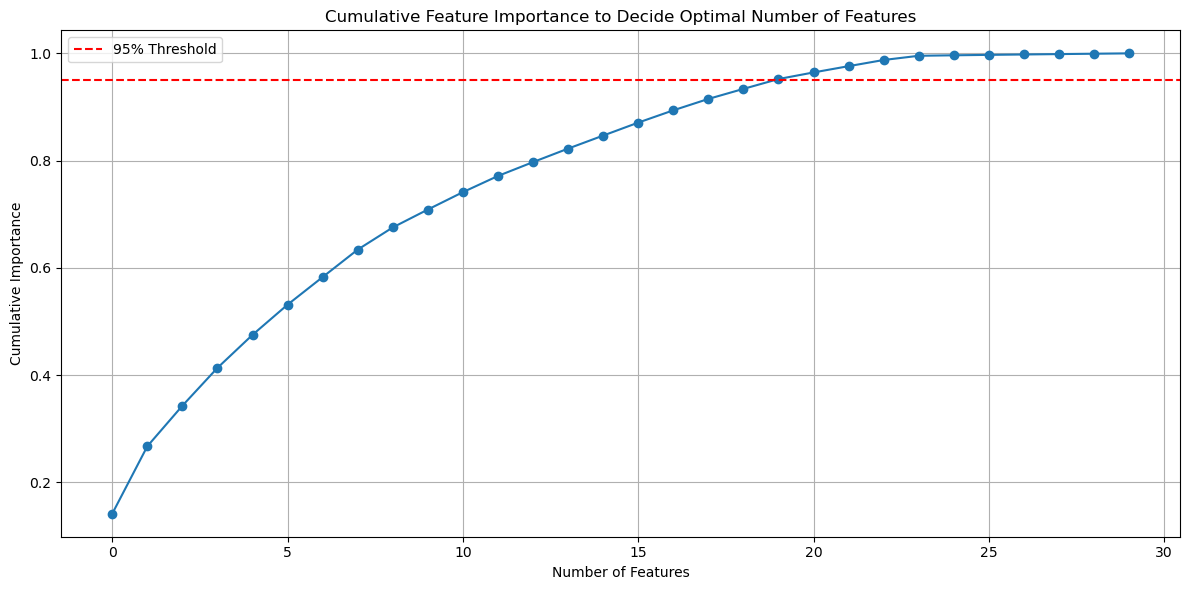

In [268]:
# 
importance_df['cumulative_importance'] = importance_df['importance'].cumsum()
importance_df['cumulative_importance'] /= importance_df['cumulative_importance'].max()


plt.figure(figsize=(12, 6))
plt.plot(range(len(importance_df)), importance_df['cumulative_importance'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance to Decide Optimal Number of Features')
plt.grid(True)


plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [185]:
importance_df

feature  importance  \
322        VarianceTable_variance_table_bank_aba_score    0.015928   
340                      PricingTool_predictions_25_50    0.014182   
344                   PricingTool_basic_5__probability    0.014020   
343                        PricingTool_projected_value    0.013799   
341                     PricingTool_predictions_50_100    0.013529   
..                                                 ...         ...   
524  PricingTool_predictions_ranked__100_10_25_0_10...    0.000000   
401     VarianceTable_variance_table_device_browser_IE    0.000000   
527  PricingTool_predictions_ranked__100_25_50_0_10...    0.000000   
528  PricingTool_predictions_ranked__100_25_50_0_10...    0.000000   
488  PricingTool_predictions_ranked__0_10_25_50_100...    0.000000   

     cumulative_importance  
322               0.015928  
340               0.030110  
344               0.044131  
343               0.057930  
341               0.071459  
..                     ...  
524               1.000000  
401               1.000000  
527               1.000000  
528               1.000000  
488               1.000000  

[622 rows x 3 columns]

In [309]:
final_features

['VarianceTable_variance_table_bank_aba_score',
 'VarianceTable_variance_table_device_device_type_Missing',
 'VarianceTable_variance_table_device_is_mobile_device_Missing',
 'VarianceTable_variance_table_device_browser_Missing',
 'VarianceTable_variance_table_device_crawler_Missing',
 'VarianceTable_variance_table_device_platform_Missing',
 'VarianceTable_variance_table_device_is_tablet_Missing',
 'PricingTool_predictions_min_TE',
 'PricingTool_basic_5_basic_worth_5_',
 'VarianceTable_cross_variance_table_driver_license_email_count_all_time',
 'VarianceTable_ssn_variance_table_email_count_all_time',
 'VarianceTable_cross_variance_table_driver_license_bank_account_count_365_days',
 'VarianceTable_ssn_variance_table_bank_account_count_365_days_VarianceTable_ssn_variance_table_bank_account_count_90_days',
 'VarianceTable_ssn_variance_table_lead_count_15_days_VarianceTable_ssn_variance_table_lead_count_365_days',
 'VarianceTable_cross_variance_table_phone_bank_account_count_365_days',
 'Va

In [269]:
X_train = X_train[final_features]
X_test = X_test[final_features]


## MODEL SELECTION

In [270]:
#baseline simple linear model to start model selection
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [271]:
y_pred = lr.predict(X_test)

In [272]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70     12920
           1       0.30      0.40      0.34      4721

    accuracy                           0.59     17641
   macro avg       0.53      0.53      0.52     17641
weighted avg       0.63      0.59      0.61     17641



In [273]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.98      0.84     12920
           1       0.44      0.04      0.07      4721

    accuracy                           0.73     17641
   macro avg       0.59      0.51      0.45     17641
weighted avg       0.66      0.73      0.63     17641



In [276]:
import lightgbm as lgb
lgc = lgb.LGBMClassifier(scale_pos_weight=3,colsample_bytree= 0.8, max_depth= 4, n_estimators= 100, subsample= 0.6)
lgc.fit(X_train, y_train)
y_pred = lgc.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 11014, number of negative: 30146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3244
[LightGBM] [Info] Number of data points in the train set: 41160, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267590 -> initscore=-1.006885
[LightGBM] [Info] Start training from score -1.006885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [278]:
#trying NN based classifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler



numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
binary_cols = [col for col in X_train.columns if X_train[col].nunique() == 2 and set(X_train[col].unique()) <= {0, 1}]


cols_to_scale = [col for col in numeric_cols if col not in binary_cols]



scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

mlp = MLPClassifier(hidden_layer_sizes=(15, 15), activation='relu', solver='adam', max_iter=200, random_state=42)
mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.98      0.84     12920
           1       0.51      0.05      0.09      4721

    accuracy                           0.73     17641
   macro avg       0.62      0.52      0.47     17641
weighted avg       0.68      0.73      0.64     17641



## HYPERPARAMTER TUNING

In [30]:
from sklearn.model_selection import GridSearchCV


def hyperparameter_tuning_model(model, param_grid, X_train, y_train,score):
    
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1,verbose=1,scoring=score)
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters: {grid_search.best_params_}")
    
    return grid_search.best_estimator_,grid_search.best_score_,grid_search.best_params_


In [295]:
#HYPERPARAMTER TUNING GRIDS FOR BEST MODEL


param_grid_lgbm = {
    "scale_pos_weight": [1,3.0],
    "n_estimators": [50, 100],
    "subsample": [0.6,0.9],
    "colsample_bytree": [0.4,0.8],
    'max_depth': [3,5,8]
    
}



In [296]:
trained_model, best_score, best_param = hyperparameter_tuning_model(LGBMClassifier(),param_grid_lgbm, X_train, y_train, score="f1")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/rujhan98/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rujhan98/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rujhan98/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rujhan98/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/rujhan98/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning:

[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3221
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Info] Number of positive: 8812, number of negative: 24116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3211
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267614 -> initscore=-1.006761
[LightGBM] [Info] Start training from score -1.006761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8812, number of negative: 24116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3211
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267614 -> initscore=-1.006761
[LightGBM] [Info] Start training from score -1.006761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8812, number of negative: 24116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3211
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267614 -> initscore=-1.006761
[LightGBM] [Info] Start training from score -1.006761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3221
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8812, number of negative: 24116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.26

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3221
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8812, number of negative: 24116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3211
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267614 -> initscore=-1.006761
[LightGBM] [Info] Start training from score -1.006761
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.26

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3221
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data point

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3221
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3211
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267614 -> initscore=-1.006761
[LightGBM] [Info] Start training from score -1.006761
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3221
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8812, number of negative: 24116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3211
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267614 -> initscore=-1.006761
[LightGBM] [Info] Start training from score -1.006761
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 11014, number of negative: 30146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3244
[LightGBM] [Info] Number of data points in the train set: 41160, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267590 -> initscore=-1.006885
[LightGBM] [Info] Start training from score -1.006885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

## EVALUATION

In [299]:
y_test_pred = trained_model.predict(X_test)

In [300]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.47      0.59     12920
           1       0.30      0.63      0.41      4721

    accuracy                           0.51     17641
   macro avg       0.54      0.55      0.50     17641
weighted avg       0.65      0.51      0.54     17641



In [301]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

In [302]:
tn, fp, fn, tp

(6127, 6793, 1766, 2955)

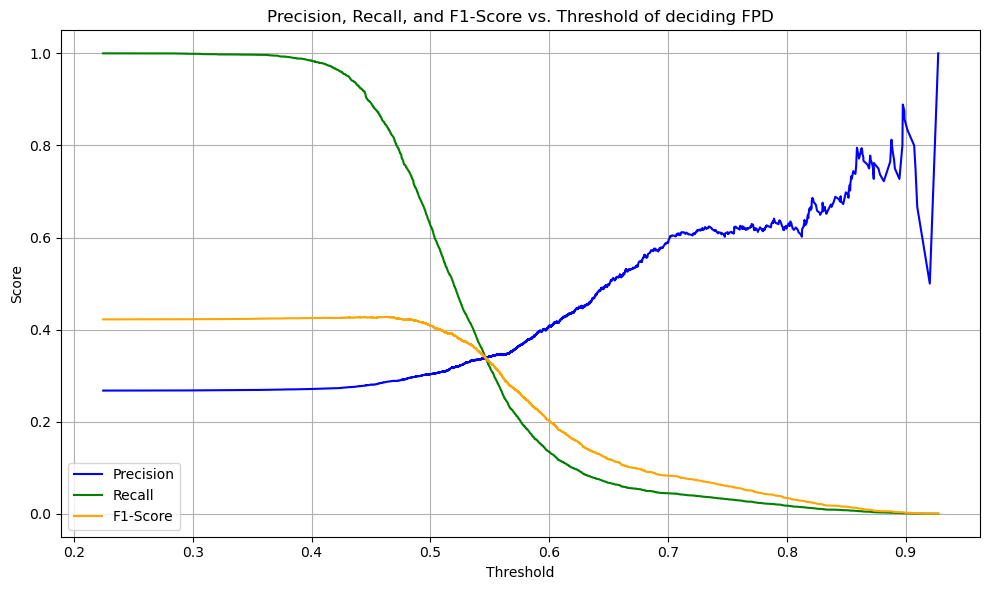

In [303]:

probs = trained_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)


f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # avoid division by zero


plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.plot(thresholds, f1_scores[:-1], label='F1-Score', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score vs. Threshold of deciding FPD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [304]:
threshold = 0.45
y_pred_custom = (probs >= threshold).astype(int)
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.81      0.16      0.27     12920
           1       0.28      0.89      0.43      4721

    accuracy                           0.36     17641
   macro avg       0.54      0.53      0.35     17641
weighted avg       0.67      0.36      0.31     17641



In [ ]:
def fdr(classifier, x, y, cutoff=0.4):
    
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.4):
    if len(y_prob.shape) > 1: 
        y_prob = y_prob[:, -1] 
    y_prob = y_prob.flatten()  
    num_fraud = np.sum(y == 1)  


    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  
    cutoff_bin = sorted_prob[:cutoff_index, 1] 


    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

In [305]:


pred_probs = pipeline.predict_proba(df3)
auc = roc_auc_score(df3['ln.fpd'], pred_probs[:, 1])
auc

0.6880244599405962

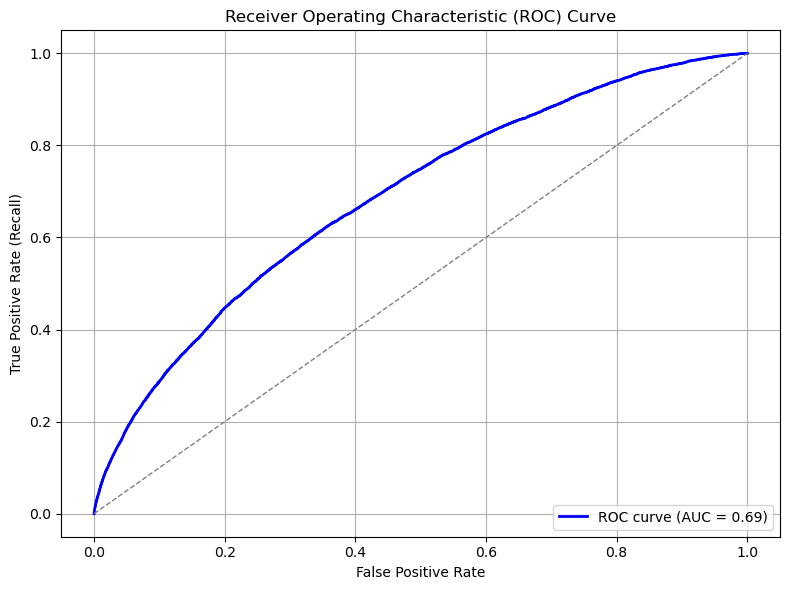

In [306]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



fpr, tpr, thresholds = roc_curve(df3['ln.fpd'], pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')  # reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
#!pip install shap

In [ ]:
#SHAP VALUES FOR INTERPRETABILITY

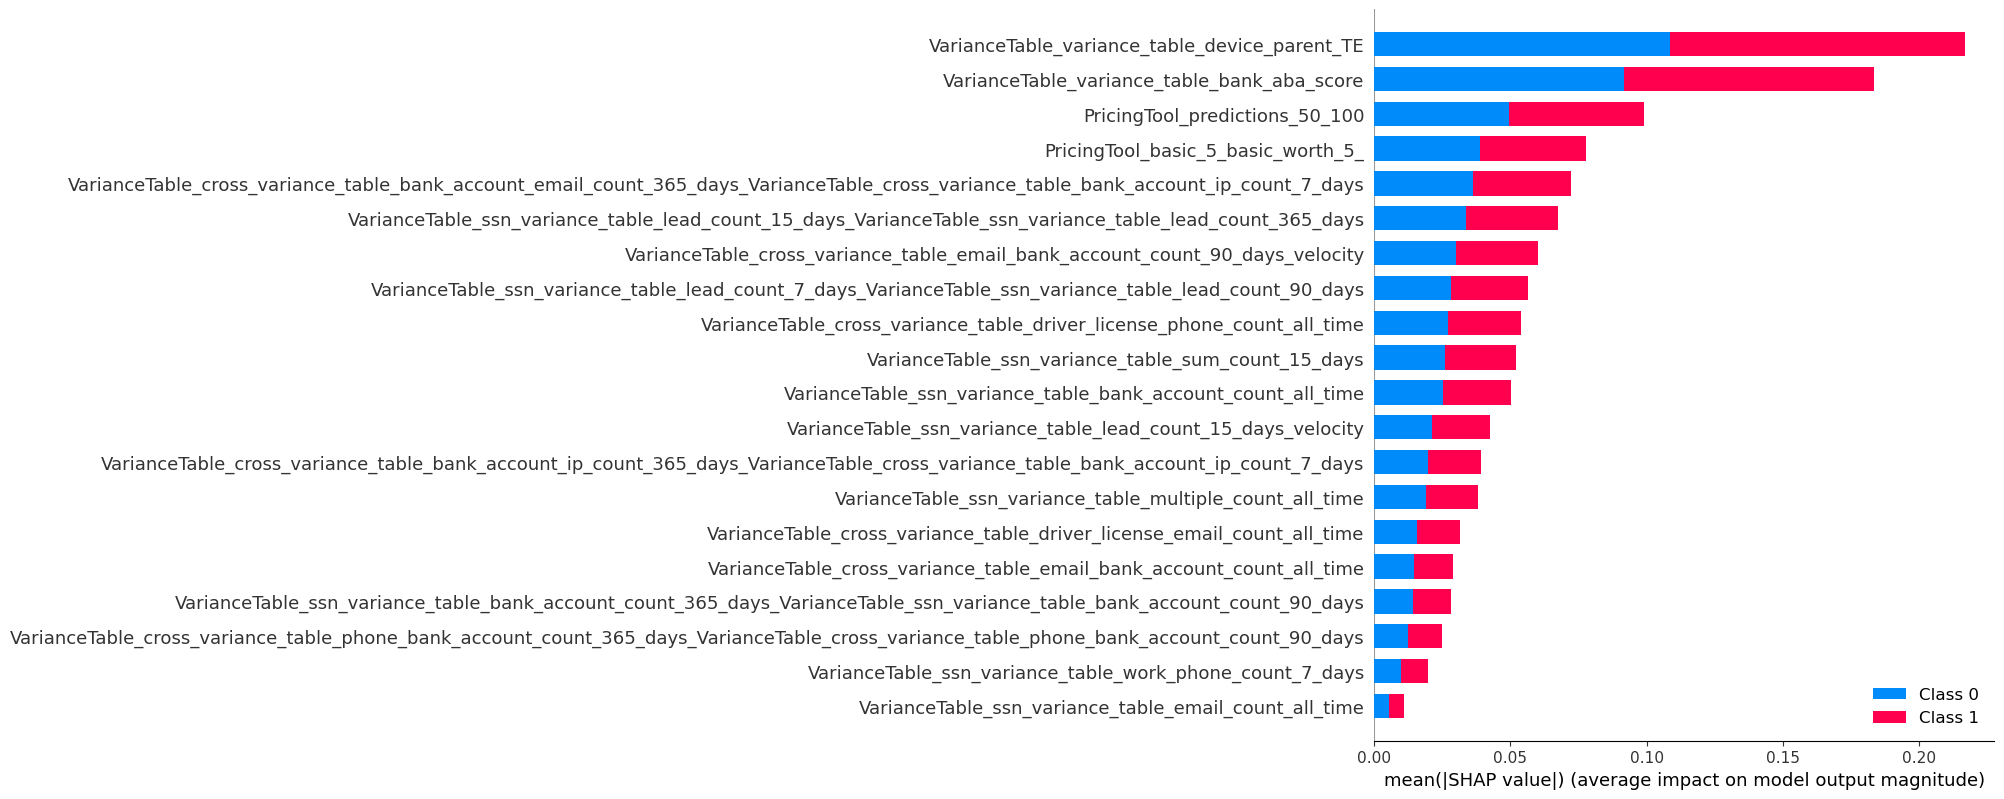

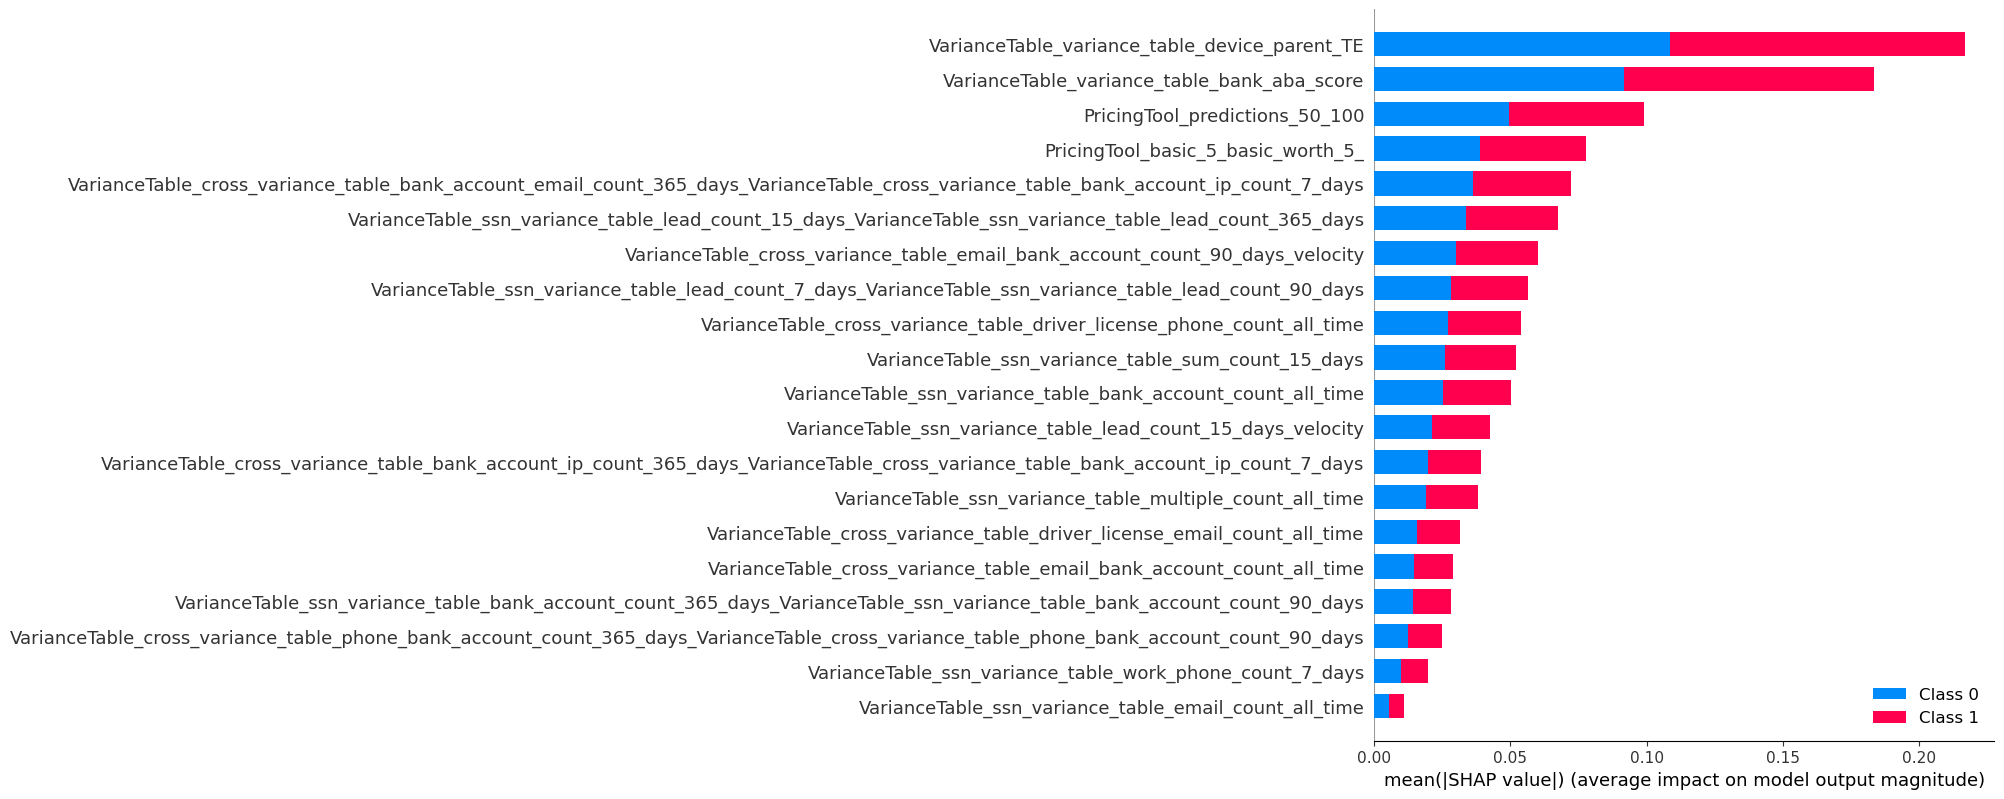

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 8812, number of negative: 24116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3211
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267614 -> initscore=-1.006761
[LightGBM] [Info] Start training from score -1.006761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Info] Number of positive: 8812, number of negative: 24116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3211
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267614 -> initscore=-1.006761
[LightGBM] [Info] Start training from score -1.006761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Info] Number of positive: 8811, number of negative: 24117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 32928, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267584 -> initscore=-1.006916
[LightGBM] [Info] Start training from score -1.006916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [307]:
import shap

explainer = shap.TreeExplainer(trained_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type='bar')  


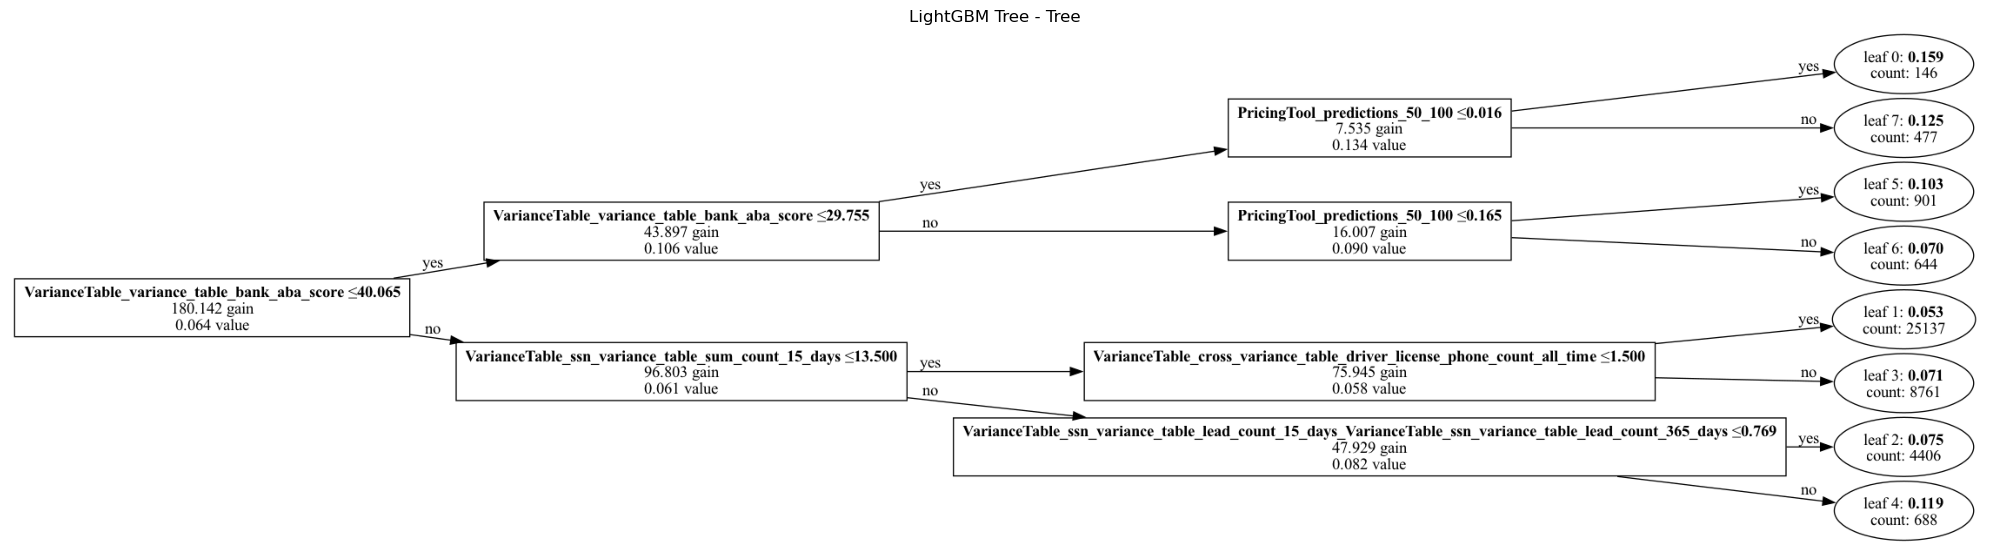

In [308]:
ax = lgb.plot_tree(trained_model, tree_index=5, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'leaf_count'])

plt.title('LightGBM Tree - Tree')
plt.tight_layout()
plt.show()

In [310]:
from graphviz import Source



dot_data = lgb.create_tree_digraph(
    booster=trained_model.booster_,
    tree_index=5, 
    name='LightGBM Tree last',
    show_info=['split_gain', 'internal_value', 'leaf_count']
).source


dot_data = dot_data.replace(
    'digraph Tree {',
    'digraph Tree {\ngraph [size="64,32", dpi=300];'
)


graph = Source(dot_data)
graph.render("lightgbm_tree_final", format='png', cleanup=False)
graph.view()

'lightgbm_tree_final.pdf'

In [ ]:
###CONVERTING ALL STEPS INTO A TRANSFORMATION PIPELINE FOR INFERENCE

In [311]:

def pre_process_and_feature_engineer(data,target_col='ln_fpd',input_file='input.json'):
    df = data.copy()
    df.columns = df.columns.str.replace(r'[^\w]+', '_', regex=True)
    categorical_columns = df.select_dtypes(exclude = np.number).columns
    with open('input.json') as f:
        input = json.load(f)
        lb_months_at_address_median = input['lb_months_at_address_median']
        final_features = input['final_features']
    for col in categorical_columns:
        if df[col].isnull().sum()>0:
            df[col] = df[col].fillna("Missing")
    days_features = [col for col in df.columns if 'day_first_seen' in col or 'day_last_seen' in col]

    df = df.drop(columns=days_features,axis=1, errors='ignore')
    df['lb_months_at_address_missing'] = df['lb_months_at_address'].isnull().astype(bool)
    df['lb_months_at_address'] = df['lb_months_at_address'].fillna(lb_months_at_address_median)
    top_exts = df['VarianceTable_variance_table_email_extension'].value_counts().nlargest(20).index
    df['email_ext_grouped'] = df['VarianceTable_variance_table_email_extension'].apply(lambda x: x if x in top_exts else 'Other')
    df = df.drop('VarianceTable_variance_table_email_extension',axis=1)
    col_TE = ['email_ext_grouped','VarianceTable_variance_table_device_parent','PricingTool_predictions_min','PricingTool_predictions_ranked','PricingTool_predictions_min_max','PricingTool_predictions_max']
    with open("TE.pkl", "rb") as f:
        TE = pickle.load(f)
    temp1 = TE.transform(df[col_TE])
    for col in temp1.columns:
          temp1.rename(columns={col:col + '_TE'}, inplace=True)

    df = pd.concat([df,temp1], axis = 1)
    df = df.drop('VarianceTable_variance_table_device_parent',axis=1)
    df['lead_datetime'] = pd.to_datetime(df['lead_datetime'], errors='coerce')
    
    
    redundant_columns = [col for col in df.columns if df[col].nunique() <= 1]

    df = df.drop(redundant_columns,axis=1, errors='ignore')
    eps = 1.e-6

    day_count_cols = sorted([col for col in df.columns if '_count_' in col and '_days' in col])

    for col in day_count_cols:

        window = int(col.split('_days')[0].split('_')[-1])
        base = col.split('count_')[0]
        all_count_cols = [i for i in day_count_cols if base in i]
        for a, b in combinations(df[all_count_cols].columns,2):
            df[f'{a}/{b}'] = df[a].div(df[b]+eps)

        rolling_mean = df[col].rolling(window).mean().shift(1)  # shift to exclude current row

        # Velocity feature = current value / rolling mean
        df[f'{col}_velocity'] = df[col] / (rolling_mean+eps)
        df[f'{col}_velocity'] = df[f'{col}_velocity'].fillna(0)
 
    scale_cols = [col for col in df.columns if 'scale_scale_between' in col]
    short_term  = [col for col in scale_cols if '24_hours_and_60_minutes' in col or '6_hours_and_60_minutes' in col]
    mid_term    = [col for col in scale_cols if '7_days_and_24_hours' in col or '30_days_and_7_days' in col]
    long_term   = [col for col in scale_cols if '90_days_and_30_days' in col or 
                   '365_days_and_90_days' in col or 'all_time' in col]
    
    df['scale_mean_short_term'] = df[short_term].mean(axis=1)
    df['scale_mean_mid_term']   = df[mid_term].mean(axis=1)
    df['scale_mean_long_term']  = df[long_term].mean(axis=1)
    

    df['day_of_week'] = df['lead_datetime'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6])


    df = df.drop(['lead_datetime'],axis=1)
    
    categorical_columns = df.select_dtypes(exclude = np.number).columns
    df2 = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    df2.columns = df2.columns.str.replace(r'[^\w]+', '_', regex=True)
    return df2[final_features] 
    
    
    




    

In [312]:
from sklearn.base import BaseEstimator, TransformerMixin


class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pre_process_and_feature_engineer(X)

In [313]:
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ("PreProcess+feature_engineering", FeatureEngineer()),
    ("model", trained_model)  
])

In [316]:
import pickle

with open("final_model_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)